<h1> Engineering Numerical Methods, AGH UST</h1>
<h3> Author: Tymoteusz Ciesielski </h3>
<h2> Lab 4 - Poisson equation. Global and local relaxation. </h2>

0. Don't judge me and my code, it is already like 2 am and I need to send my report, right?
1. We will be solving the Poisson equation for the problem of density of electircal potential in the given area grid. 

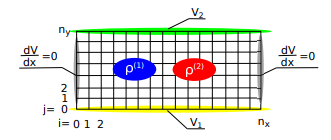

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, fabs

In [171]:
#function defining potential in the given point, created by the charged body p1
def potential_density1(x, y, x_max, y_max):
    sigma_x = 0.1*x_max
    sigma_y = 0.1*y_max
    return +1 * exp( -(x - 0.35*x_max)**2 / (sigma_x**2) - (y - 0.5*y_max)**2 / (sigma_y**2)  )

In [172]:
#function defining potential in the given point, created by the charged body p2
def potential_density2(x, y, x_max, y_max):
    sigma_x = 0.1*x_max
    sigma_y = 0.1*y_max
    return -1 * exp( -(x - 0.65*x_max)**2 / (sigma_x**2) - (y - 0.5*y_max)**2 / (sigma_y**2) )

In [207]:
#to fix - V1 and V2 parameters are not being used anywhere, they should be boundary elemens
class Global_relaxation_method():
    #calculation parameters
    epsilon = 1
    delta = 0.1
    n_x = 150
    n_y = 100
    V1 = 10
    V2 = 0
    x_max = delta * n_x
    y_max = delta * n_y
    
    
    
    def __init__(self, omega_G, TOL, max_iterations):
        self.omega_G = omega_G
        self.TOL = TOL
        self.max_iterations = max_iterations
        self.V_new = np.zeros((n_x, n_y))
        self.V_old = np.zeros((n_x, n_y))
        self.potential_values = np.zeros((n_x, n_y))
        self.calculate_basic_potential()
        
        self.integral_values = np.zeros(max_iterations+1)
        self.integral_values[0] = 1
    
    # calculating next step for one node in a grid
    def calculate_next_step(self, x,y):
        if x == 0 or y == 0:
            print('We do not calculate sides here')
        else:
            return 1/4*(self.V_old[x+1,y] + self.V_old[x-1,y] + self.V_old[x,y+1] + self.V_old[x,y-1]+ \
                        delta**2/epsilon*(potential_density1(x*delta,y*delta,x_max,y_max) + potential_density2(x*delta,y*delta,x_max,y_max) ) )
    
    def calculate_new_grid(self):
        #Non-boundary elements
        for x in range(1, n_x-1):
            for y in range(1, n_y-1):
                self.V_new[x,y] = self.calculate_next_step(x,y)
        # Neuman's boundary elements
        
        self.V_new[0,:] = self.V_new[1,:]
        self.V_new[-1,:] = self.V_new[-2,:]
        # mixin old and new solutions together
        for x in range(1, n_x):
            for y in range(1, n_y):
                self.V_old[x,y] = (1-self.omega_G) * self.V_old[x,y] + self.omega_G * self.V_new[x,y]
    
    def calculate_density(self):
        #self.calculate_basic_potential()
        for i in range(self.max_iterations):
            self.calculate_new_grid()
            s = self.calculate_stop_condition()
            print('Iteration {} Integral value = {}'.format(i,s))
            print('Iteration {} Eror = {}'.format(i, abs((self.integral_values[i] - s)/self.integral_values[i] )) )
            if abs( (self.integral_values[i] - s)/self.integral_values[i] ) < self.TOL:
                break
            else:
                self.integral_values[i+1] = s
                continue
    
    #we calculate potential coming from 2 charged bodies in the exercise
    def calculate_basic_potential(self):
        for x in range(0, n_x):
            for y in range(0, n_y):
                self.potential_values[x,y] = potential_density1(x*delta,y*delta ,x_max,y_max) + potential_density2(x*delta,y*delta,x_max,y_max)
    
    # featured for the stop condition
    def calculate_stop_condition(self):
        s = 0
        for i in range(0, n_x-1):
            for j in range(0, n_y-1):
                s += delta**2*( 1/2*( (self.V_old[i+1,j] - self.V_old[i,j])/delta)**2 \
                + 1/2*( (self.V_old[i,j+1] - self.V_old[i,j])/delta)**2 - self.potential_values[i,j] * V_old[i,j] )
        return s
    
    def plot():
        pass
        
        

In [222]:
class Local_relaxation_method():
    #calculation parameters
    epsilon = 1
    delta = 0.1
    n_x = 150
    n_y = 100
    V1 = 10
    V2 = 0
    x_max = delta * n_x
    y_max = delta * n_y
    
    def __init__(self, omega_L, TOL, max_iterations):
        self.omega_L = omega_L
        self.TOL = TOL
        self.max_iterations = max_iterations
        self.V = np.zeros((n_x, n_y))
        self.potential_values = np.zeros((n_x, n_y))
        self.calculate_basic_potential()
        
        self.integral_values = np.zeros(max_iterations+1)
        self.integral_values[0] = 1
    
    # calculating next step for one node in a grid
    def calculate_next_step(self, x,y):
        if x == 0 or y == 0:
            print('We do not calculate sides here')
        else:
            return (1-self.omega_L)*self.V[x,y] + self.omega_L/4 \
        * (self.V[x+1,y] + self.V[x-1,y] +self.V[x,y-1] + self.V[x,y+1] + delta**2/epsilon*self.potential_values[x,y])
    
    def calculate_new_grid(self):
        #Non-boundary elements
        for x in range(1, n_x-1):
            for y in range(1, n_y-1):
                self.V[x,y] = self.calculate_next_step(x,y)
        # Neuman's boundary elements
        
        self.V[0,:] = self.V[1,:]
        self.V[-1,:] = self.V[-2,:]
    
    def calculate_density(self):
        #self.calculate_basic_potential()
        for i in range(self.max_iterations):
            self.calculate_new_grid()
            s = self.calculate_stop_condition()
            print('Iteration {} Integral value = {}'.format(i,s))
            print('Iteration {} Eror = {}'.format(i, abs((self.integral_values[i] - s)/self.integral_values[i] )) )
            if abs( (self.integral_values[i] - s)/self.integral_values[i] ) < self.TOL:
                break
            else:
                self.integral_values[i+1] = s
                continue
    
    #we calculate potential coming from 2 charged bodies in the exercise
    def calculate_basic_potential(self):
        for x in range(0, n_x):
            for y in range(0, n_y):
                self.potential_values[x,y] = potential_density1(x*delta,y*delta ,x_max,y_max) + potential_density2(x*delta,y*delta,x_max,y_max)
    
    # featured for the stop condition
    def calculate_stop_condition(self):
        s = 0
        for i in range(0, n_x-1):
            for j in range(0, n_y-1):
                s += delta**2*( 1/2*( (self.V[i+1,j] - self.V[i,j])/delta)**2 \
                + 1/2*( (self.V[i,j+1] - self.V[i,j])/delta)**2 - self.potential_values[i,j] * self.V[i,j] )
        return s
    
    def plot():
        pass
        
        

In [174]:
# task parameters
epsilon = 1
delta = 0.1
n_x = 150
n_y = 100
V1 = 10
V2 = 0
x_max = delta * n_x
y_max = delta * n_y

<h2>2. Metoda relaksacji globalnej.</h2>

In [181]:
# starting values of the potential are 0s in all the nodes

<h3> Parametr omega G = 0.6 </h3>

In [208]:
omega_G_1 = 0.6
first = Global_relaxation_method(omega_G_1, TOL=1e-4,max_iterations=2000)
first.calculate_new_grid()
first.calculate_density()

Iteration 0 Integral value = 3.103021443778565e-05
Iteration 0 Eror = 0.9999689697855623
Iteration 1 Integral value = 6.950411012502037e-05
Iteration 1 Eror = 1.2398849438947113
Iteration 2 Integral value = 0.00012300960243746034
Iteration 2 Eror = 0.7698176728857773
Iteration 3 Integral value = 0.00019134533779515913
Iteration 3 Eror = 0.5555317146272508
Iteration 4 Integral value = 0.0002743133473204722
Iteration 4 Eror = 0.4336035070482499
Iteration 5 Integral value = 0.0003717189742870765
Iteration 5 Eror = 0.35508890806107307
Iteration 6 Integral value = 0.0004833708034857432
Iteration 6 Eror = 0.3003662361137331
Iteration 7 Integral value = 0.0006090805924462796
Iteration 7 Eror = 0.2600690568275998
Iteration 8 Integral value = 0.0007486632044572262
Iteration 8 Eror = 0.2291693640251027
Iteration 9 Integral value = 0.0009019365433270731
Iteration 9 Eror = 0.20472936022142108
Iteration 10 Integral value = 0.0010687214898328337
Iteration 10 Eror = 0.18491871489154052
Iteration 11 I

Iteration 91 Integral value = 0.04722128702859605
Iteration 91 Eror = 0.018445942836725723
Iteration 92 Integral value = 0.04808164977410589
Iteration 92 Eror = 0.018219807202392076
Iteration 93 Integral value = 0.04894705437354508
Iteration 93 Eror = 0.017998646126016496
Iteration 94 Integral value = 0.04981744560094972
Iteration 94 Eror = 0.01778230045800409
Iteration 95 Integral value = 0.05069276889385665
Iteration 95 Eror = 0.017570617729348974
Iteration 96 Integral value = 0.05157297034341969
Iteration 96 Eror = 0.01736345180524778
Iteration 97 Integral value = 0.05245799668470678
Iteration 97 Eror = 0.017160662560131334
Iteration 98 Integral value = 0.053347795287169486
Iteration 98 Eror = 0.0169621155724026
Iteration 99 Integral value = 0.054242314145286324
Iteration 99 Eror = 0.016767681837678048
Iteration 100 Integral value = 0.055141501869366095
Iteration 100 Eror = 0.01657723749896299
Iteration 101 Integral value = 0.05604530767652364
Iteration 101 Eror = 0.0163906635930722

Iteration 181 Integral value = 0.139708015362142
Iteration 181 Eror = 0.008297839096217353
Iteration 182 Integral value = 0.14085967066284646
Iteration 182 Eror = 0.008243301558033139
Iteration 183 Integral value = 0.142013225815103
Iteration 183 Eror = 0.008189392654606043
Iteration 184 Integral value = 0.14316865989538785
Iteration 184 Eror = 0.008136101927500652
Iteration 185 Integral value = 0.14432595218189131
Iteration 185 Eror = 0.008083419145985496
Iteration 186 Integral value = 0.145485082152172
Iteration 186 Eror = 0.008031334300984676
Iteration 187 Integral value = 0.14664602948084018
Iteration 187 Eror = 0.007979837599114551
Iteration 188 Integral value = 0.1478087740372691
Iteration 188 Eror = 0.007928919456907905
Iteration 189 Integral value = 0.14897329588335317
Iteration 189 Eror = 0.007878570495351232
Iteration 190 Integral value = 0.150139575271278
Iteration 190 Eror = 0.007828781534363219
Iteration 191 Integral value = 0.15130759264132618
Iteration 191 Eror = 0.00777

Iteration 270 Integral value = 0.24767998884110604
Iteration 270 Eror = 0.005098753697054992
Iteration 271 Integral value = 0.2489370746422316
Iteration 271 Eror = 0.0050754435471653345
Iteration 272 Integral value = 0.2501947838208831
Iteration 272 Eror = 0.005052317660834834
Iteration 273 Integral value = 0.2514531069473013
Iteration 273 Eror = 0.0050293739429795835
Iteration 274 Integral value = 0.25271203466997916
Iteration 274 Eror = 0.005006610329701453
Iteration 275 Integral value = 0.25397155771489116
Iteration 275 Eror = 0.004984024787568329
Iteration 276 Integral value = 0.2552316668847532
Iteration 276 Eror = 0.004961615313147085
Iteration 277 Integral value = 0.25649235305829254
Iteration 277 Eror = 0.004939379932461939
Iteration 278 Integral value = 0.25775360718951384
Iteration 278 Eror = 0.004917316700411174
Iteration 279 Integral value = 0.2590154203069739
Iteration 279 Eror = 0.0048954237002483214
Iteration 280 Integral value = 0.26027778351308645
Iteration 280 Eror = 

Iteration 359 Integral value = 0.36109499443479326
Iteration 359 Eror = 0.0035656420523499893
Iteration 360 Integral value = 0.3623779821979121
Iteration 360 Eror = 0.0035530477655251512
Iteration 361 Integral value = 0.3636609921142593
Iteration 361 Eror = 0.003540529445429863
Iteration 362 Integral value = 0.36494401952716976
Iteration 362 Eror = 0.003528086434157225
Iteration 363 Integral value = 0.36622705981526366
Iteration 363 Eror = 0.003515718081244989
Iteration 364 Integral value = 0.36751010839216236
Iteration 364 Eror = 0.003503423743581138
Iteration 365 Integral value = 0.3687931607061832
Iteration 365 Eror = 0.0034912027852352233
Iteration 366 Integral value = 0.37007621224007015
Iteration 366 Eror = 0.0034790545774496463
Iteration 367 Integral value = 0.37135925851070284
Iteration 367 Eror = 0.003466978498473106
Iteration 368 Integral value = 0.37264229506882135
Iteration 368 Eror = 0.0034549739335003895
Iteration 369 Integral value = 0.37392531749874414
Iteration 369 Ero

Iteration 448 Integral value = 0.4749143658699017
Iteration 448 Eror = 0.0026821869823513873
Iteration 449 Integral value = 0.4761844886329548
Iteration 449 Eror = 0.002674424810726916
Iteration 450 Integral value = 0.47745433006977017
Iteration 450 Eror = 0.0026667005480603863
Iteration 451 Integral value = 0.4787238877839161
Iteration 451 Eror = 0.002659013929060862
Iteration 452 Integral value = 0.4799931593966378
Iteration 452 Eror = 0.002651364690818572
Iteration 453 Integral value = 0.481262142546764
Iteration 453 Eror = 0.002643752572893719
Iteration 454 Integral value = 0.48253083489054593
Iteration 454 Eror = 0.002636177317144012
Iteration 455 Integral value = 0.48379923410154957
Iteration 455 Eror = 0.002628638667809384
Iteration 456 Integral value = 0.4850673378705269
Iteration 456 Eror = 0.00262113637143785
Iteration 457 Integral value = 0.4863351439052989
Iteration 457 Eror = 0.002613670176882536
Iteration 458 Integral value = 0.48760264993060914
Iteration 458 Eror = 0.002

Iteration 537 Integral value = 0.5866199112290915
Iteration 537 Eror = 0.0021146403758760587
Iteration 538 Integral value = 0.5878573473427224
Iteration 538 Eror = 0.002109434217870701
Iteration 539 Integral value = 0.5890943458437495
Iteration 539 Eror = 0.0021042494520459305
Iteration 540 Integral value = 0.590330905509996
Iteration 540 Eror = 0.0020990859528202906
Iteration 541 Integral value = 0.5915670251288433
Iteration 541 Eror = 0.002093943595548981
Iteration 542 Integral value = 0.5928027034972014
Iteration 542 Eror = 0.002088822256597228
Iteration 543 Integral value = 0.5940379394214004
Iteration 543 Eror = 0.002083721813196441
Iteration 544 Integral value = 0.5952727317171679
Iteration 544 Eror = 0.00207864214358128
Iteration 545 Integral value = 0.5965070792095502
Iteration 545 Eror = 0.0020735831268830006
Iteration 546 Integral value = 0.5977409807328554
Iteration 546 Eror = 0.0020685446431588884
Iteration 547 Integral value = 0.5989744351305905
Iteration 547 Eror = 0.0020

Iteration 626 Integral value = 0.6949202510337774
Iteration 626 Eror = 0.001722826795891572
Iteration 627 Integral value = 0.696114904744024
Iteration 627 Eror = 0.0017191234655623265
Iteration 628 Integral value = 0.6973090434262998
Iteration 628 Eror = 0.0017154332914548244
Iteration 629 Integral value = 0.6985026665096492
Iteration 629 Eror = 0.0017117562070963113
Iteration 630 Integral value = 0.6996957734285585
Iteration 630 Eror = 0.0017080921464067162
Iteration 631 Integral value = 0.7008883636229313
Iteration 631 Eror = 0.001704441043753935
Iteration 632 Integral value = 0.7020804365380752
Iteration 632 Eror = 0.0017008028339663135
Iteration 633 Integral value = 0.7032719916246166
Iteration 633 Eror = 0.0016971774522260615
Iteration 634 Integral value = 0.7044630283385537
Iteration 634 Eror = 0.0016935648342622906
Iteration 635 Integral value = 0.7056535461411225
Iteration 635 Eror = 0.0016899649160817321
Iteration 636 Integral value = 0.7068435444988389
Iteration 636 Eror = 0.

Iteration 715 Integral value = 0.7991747953699282
Iteration 715 Eror = 0.0014381396569732678
Iteration 716 Integral value = 0.8003219222372165
Iteration 716 Eror = 0.0014353891963739417
Iteration 717 Integral value = 0.801468501324617
Iteration 717 Eror = 0.0014326473579473048
Iteration 718 Integral value = 0.802614532438108
Iteration 718 Eror = 0.0014299141034200317
Iteration 719 Integral value = 0.80376001538687
Iteration 719 Eror = 0.0014271893947427074
Iteration 720 Integral value = 0.8049049499832649
Iteration 720 Eror = 0.0014244731940836572
Iteration 721 Integral value = 0.8060493360428242
Iteration 721 Eror = 0.0014217654638391131
Iteration 722 Integral value = 0.8071931733842392
Iteration 722 Eror = 0.001419066166632532
Iteration 723 Integral value = 0.8083364618293208
Iteration 723 Eror = 0.00141637526527665
Iteration 724 Integral value = 0.8094792012029941
Iteration 724 Eror = 0.0014136927228139199
Iteration 725 Integral value = 0.8106213913332861
Iteration 725 Eror = 0.0014

Iteration 806 Integral value = 0.9013043745454745
Iteration 806 Eror = 0.0012190338202455867
Iteration 807 Integral value = 0.9024012029635158
Iteration 807 Eror = 0.0012169345329033714
Iteration 808 Integral value = 0.9034974770622876
Iteration 808 Eror = 0.0012148411318286987
Iteration 809 Integral value = 0.9045931968745341
Iteration 809 Eror = 0.0012127535937446821
Iteration 810 Integral value = 0.9056883624349236
Iteration 810 Eror = 0.0012106718955806652
Iteration 811 Integral value = 0.9067829737799417
Iteration 811 Eror = 0.0012085960142794083
Iteration 812 Integral value = 0.9078770309479792
Iteration 812 Eror = 0.0012065259270109228
Iteration 813 Integral value = 0.9089705339792417
Iteration 813 Eror = 0.0012044616109745923
Iteration 814 Integral value = 0.910063482915796
Iteration 814 Eror = 0.0012024030435504485
Iteration 815 Integral value = 0.9111558778015165
Iteration 815 Eror = 0.001200350202186525
Iteration 816 Integral value = 0.9122477186821129
Iteration 816 Eror = 0

Iteration 895 Integral value = 0.9967592773099985
Iteration 895 Eror = 0.0010528724485435194
Iteration 896 Integral value = 0.9978070885863325
Iteration 896 Eror = 0.0010512179823014027
Iteration 897 Integral value = 0.9988543547058023
Iteration 897 Eror = 0.0010495677285211052
Iteration 898 Integral value = 0.9999010758314341
Iteration 898 Eror = 0.0010479216721641582
Iteration 899 Integral value = 1.00094725212737
Iteration 899 Eror = 0.0010462797982949748
Iteration 900 Integral value = 1.0019928837588292
Iteration 900 Eror = 0.001044642092015319
Iteration 901 Integral value = 1.0030379708921375
Iteration 901 Eror = 0.0010430085385315492
Iteration 902 Integral value = 1.0040825136946872
Iteration 902 Eror = 0.0010413791230860045
Iteration 903 Integral value = 1.0051265123349453
Iteration 903 Eror = 0.001039753831003993
Iteration 904 Integral value = 1.0061699669824393
Iteration 904 Eror = 0.0010381326476704103
Iteration 905 Integral value = 1.0072128778077811
Iteration 905 Eror = 0.0

Iteration 985 Integral value = 1.088900623562399
Iteration 985 Eror = 0.0009192387483361495
Iteration 986 Integral value = 1.0899001368970218
Iteration 986 Eror = 0.000917910517263566
Iteration 987 Integral value = 1.0908991234336176
Iteration 987 Eror = 0.0009165853850059578
Iteration 988 Integral value = 1.0918975834105866
Iteration 988 Eror = 0.0009152633415144276
Iteration 989 Integral value = 1.0928955170669352
Iteration 989 Eror = 0.0009139443767532725
Iteration 990 Integral value = 1.0938929246422424
Iteration 990 Eror = 0.000912628480702341
Iteration 991 Integral value = 1.094889806376708
Iteration 991 Eror = 0.0009113156434316366
Iteration 992 Integral value = 1.095886162511115
Iteration 992 Eror = 0.00091000585502213
Iteration 993 Integral value = 1.096881993286848
Iteration 993 Eror = 0.0009086991056181669
Iteration 994 Integral value = 1.097877298945877
Iteration 994 Eror = 0.0009073953853927008
Iteration 995 Integral value = 1.0988720797307245
Iteration 995 Eror = 0.000906

Iteration 1072 Integral value = 1.173914001758605
Iteration 1072 Eror = 0.0008142942458146432
Iteration 1073 Integral value = 1.1748686309376963
Iteration 1073 Eror = 0.0008132019702135693
Iteration 1074 Integral value = 1.1758227559158
Iteration 1074 Eror = 0.0008121120548960873
Iteration 1075 Integral value = 1.1767763769700497
Iteration 1075 Eror = 0.0008110244928087215
Iteration 1076 Integral value = 1.1777294943778385
Iteration 1076 Eror = 0.0008099392768597904
Iteration 1077 Integral value = 1.1786821084169208
Iteration 1077 Eror = 0.0008088564000730495
Iteration 1078 Integral value = 1.1796342193652778
Iteration 1078 Eror = 0.0008077758553880004
Iteration 1079 Integral value = 1.1805858275012429
Iteration 1079 Eror = 0.0008066976358799545
Iteration 1080 Integral value = 1.1815369331034016
Iteration 1080 Eror = 0.0008056217345686526
Iteration 1081 Integral value = 1.1824875364506429
Iteration 1081 Eror = 0.0008045481445463153
Iteration 1082 Integral value = 1.183437637822147
Iter

Iteration 1160 Integral value = 1.2560223002476685
Iteration 1160 Eror = 0.0007264911766289915
Iteration 1161 Integral value = 1.2569336477037714
Iteration 1161 Eror = 0.0007255822256684301
Iteration 1162 Integral value = 1.257844516225578
Iteration 1162 Eror = 0.0007246751039489493
Iteration 1163 Integral value = 1.2587549061074819
Iteration 1163 Eror = 0.00072376980633159
Iteration 1164 Integral value = 1.2596648176439744
Iteration 1164 Eror = 0.0007228663277320034
Iteration 1165 Integral value = 1.2605742511296842
Iteration 1165 Eror = 0.0007219646631163265
Iteration 1166 Integral value = 1.2614832068593331
Iteration 1166 Eror = 0.0007210648074354291
Iteration 1167 Integral value = 1.2623916851277108
Iteration 1167 Eror = 0.0007201667556395802
Iteration 1168 Integral value = 1.263299686229716
Iteration 1168 Eror = 0.0007192705027308573
Iteration 1169 Integral value = 1.2642072104603537
Iteration 1169 Eror = 0.0007183760437289914
Iteration 1170 Integral value = 1.265114258114726
Iter

Iteration 1247 Integral value = 1.3335492089446634
Iteration 1247 Eror = 0.0006537529908229437
Iteration 1248 Integral value = 1.3344199977473148
Iteration 1248 Eror = 0.0006529858791941134
Iteration 1249 Integral value = 1.3352903334436244
Iteration 1249 Eror = 0.0006522202138598134
Iteration 1250 Integral value = 1.3361602163311679
Iteration 1250 Eror = 0.0006514559910728608
Iteration 1251 Integral value = 1.337029646707449
Iteration 1251 Eror = 0.0006506932070379631
Iteration 1252 Integral value = 1.3378986248700073
Iteration 1252 Eror = 0.0006499318580543892
Iteration 1253 Integral value = 1.3387671511162782
Iteration 1253 Eror = 0.0006491719403293809
Iteration 1254 Integral value = 1.3396352257437325
Iteration 1254 Eror = 0.0006484134501884793
Iteration 1255 Integral value = 1.3405028490497979
Iteration 1255 Eror = 0.0006476563839112966
Iteration 1256 Integral value = 1.3413700213318642
Iteration 1256 Eror = 0.0006469007377947972
Iteration 1257 Integral value = 1.3422367428873256


Iteration 1335 Integral value = 1.408476689862968
Iteration 1335 Eror = 0.0005913972706688059
Iteration 1336 Integral value = 1.4093087393955726
Iteration 1336 Eror = 0.0005907442690340721
Iteration 1337 Integral value = 1.4101403618070496
Iteration 1337 Eror = 0.0005900924249101861
Iteration 1338 Integral value = 1.4109715573891919
Iteration 1338 Eror = 0.0005894417354859165
Iteration 1339 Integral value = 1.4118023264336939
Iteration 1339 Eror = 0.0005887921979371364
Iteration 1340 Integral value = 1.4126326692321256
Iteration 1340 Eror = 0.0005881438094306375
Iteration 1341 Integral value = 1.413462586075961
Iteration 1341 Eror = 0.0005874965671625103
Iteration 1342 Integral value = 1.4142920772565923
Iteration 1342 Eror = 0.0005868504683481377
Iteration 1343 Integral value = 1.4151211430652781
Iteration 1343 Eror = 0.0005862055101758071
Iteration 1344 Integral value = 1.4159497837931658
Iteration 1344 Eror = 0.0005855616898584221
Iteration 1345 Integral value = 1.4167779997313255
I

Iteration 1421 Integral value = 1.4785014432206027
Iteration 1421 Eror = 0.0005391973911493345
Iteration 1422 Integral value = 1.4792978149763594
Iteration 1422 Eror = 0.0005386344121666289
Iteration 1423 Integral value = 1.4800937842665804
Iteration 1423 Eror = 0.0005380723760710735
Iteration 1424 Integral value = 1.4808893513720465
Iteration 1424 Eror = 0.0005375112806518832
Iteration 1425 Integral value = 1.4816845165734094
Iteration 1425 Eror = 0.0005369511237461401
Iteration 1426 Integral value = 1.482479280151181
Iteration 1426 Eror = 0.0005363919031897799
Iteration 1427 Integral value = 1.4832736423856983
Iteration 1427 Eror = 0.0005358336168018645
Iteration 1428 Integral value = 1.4840676035571854
Iteration 1428 Eror = 0.0005352762624502006
Iteration 1429 Integral value = 1.4848611639456797
Iteration 1429 Eror = 0.0005347198379590128
Iteration 1430 Integral value = 1.4856543238310933
Iteration 1430 Eror = 0.0005341643412007474
Iteration 1431 Integral value = 1.4864470834931567


Iteration 1509 Integral value = 1.5470719711972085
Iteration 1509 Eror = 0.0004930391162110777
Iteration 1510 Integral value = 1.5478339836747004
Iteration 1510 Eror = 0.000492551407871588
Iteration 1511 Integral value = 1.5485956177875504
Iteration 1511 Eror = 0.0004920644726004973
Iteration 1512 Integral value = 1.5493568738021108
Iteration 1512 Eror = 0.0004915783086407309
Iteration 1513 Integral value = 1.5501177519846314
Iteration 1513 Eror = 0.0004910929143479932
Iteration 1514 Integral value = 1.5508782526011544
Iteration 1514 Eror = 0.0004906082880151008
Iteration 1515 Integral value = 1.5516383759175414
Iteration 1515 Eror = 0.0004901244279569234
Iteration 1516 Integral value = 1.5523981221994851
Iteration 1516 Eror = 0.0004896413325008706
Iteration 1517 Integral value = 1.5531574917125328
Iteration 1517 Eror = 0.0004891589999940039
Iteration 1518 Integral value = 1.553916484722004
Iteration 1518 Eror = 0.0004886774287353535
Iteration 1519 Integral value = 1.5546751014930653
I

Iteration 1597 Integral value = 1.6127095067501735
Iteration 1597 Eror = 0.00045290427020240663
Iteration 1598 Integral value = 1.6134392232576542
Iteration 1598 Eror = 0.000452478579946575
Iteration 1599 Integral value = 1.614168584153885
Iteration 1599 Eror = 0.0004520535299484324
Iteration 1600 Integral value = 1.6148975896892175
Iteration 1600 Eror = 0.00045162911884728845
Iteration 1601 Integral value = 1.6156262401138703
Iteration 1601 Eror = 0.000451205345345207
Iteration 1602 Integral value = 1.6163545356778124
Iteration 1602 Eror = 0.000450782208074758
Iteration 1603 Integral value = 1.6170824766308594
Iteration 1603 Eror = 0.000450359705732318
Iteration 1604 Integral value = 1.6178100632226673
Iteration 1604 Eror = 0.0004499378370136334
Iteration 1605 Integral value = 1.618537295702631
Iteration 1605 Eror = 0.00044951660055507633
Iteration 1606 Integral value = 1.619264174320027
Iteration 1606 Eror = 0.0004490959950851212
Iteration 1607 Integral value = 1.6199906993239226
Ite

Iteration 1684 Integral value = 1.674890621507574
Iteration 1684 Eror = 0.0004181303031730843
Iteration 1685 Integral value = 1.6755903165603179
Iteration 1685 Eror = 0.0004177556693905253
Iteration 1686 Integral value = 1.6762896770803164
Iteration 1686 Eror = 0.00041738157178789766
Iteration 1687 Integral value = 1.676988703301552
Iteration 1687 Eror = 0.00041700800929178535
Iteration 1688 Integral value = 1.6776873954577873
Iteration 1688 Eror = 0.000416634980819943
Iteration 1689 Integral value = 1.6783857537826405
Iteration 1689 Eror = 0.0004162624853378303
Iteration 1690 Integral value = 1.679083778509518
Iteration 1690 Eror = 0.00041589052177329176
Iteration 1691 Integral value = 1.679781469871642
Iteration 1691 Eror = 0.000415519089073248
Iteration 1692 Integral value = 1.6804788281020149
Iteration 1692 Eror = 0.0004151481861662376
Iteration 1693 Integral value = 1.6811758534335153
Iteration 1693 Eror = 0.0004147778120404186
Iteration 1694 Integral value = 1.6818725460987753
It

Iteration 1772 Integral value = 1.7352084310706648
Iteration 1772 Eror = 0.00038710391551460827
Iteration 1773 Integral value = 1.735879562249467
Iteration 1773 Eror = 0.00038677265899868143
Iteration 1774 Integral value = 1.7365503787662793
Iteration 1774 Eror = 0.0003864418542626572
Iteration 1775 Integral value = 1.737220880838606
Iteration 1775 Eror = 0.00038611150043520577
Iteration 1776 Integral value = 1.737891068683789
Iteration 1776 Eror = 0.00038578159667260827
Iteration 1777 Integral value = 1.7385609425189474
Iteration 1777 Eror = 0.00038545214209876905
Iteration 1778 Integral value = 1.7392305025610473
Iteration 1778 Eror = 0.0003851231358791094
Iteration 1779 Integral value = 1.7398997490268728
Iteration 1779 Eror = 0.0003847945771650623
Iteration 1780 Integral value = 1.7405686821329898
Iteration 1780 Eror = 0.0003844664650886156
Iteration 1781 Integral value = 1.741237302095819
Iteration 1781 Eror = 0.00038413879882626784
Iteration 1782 Integral value = 1.74190560913157

Iteration 1859 Integral value = 1.7924423403442429
Iteration 1859 Eror = 0.0003598880671043598
Iteration 1860 Integral value = 1.7930868902589343
Iteration 1860 Eror = 0.0003595931094595995
Iteration 1861 Integral value = 1.7937311437536057
Iteration 1861 Eror = 0.0003592985360449031
Iteration 1862 Integral value = 1.7943751010300502
Iteration 1862 Eror = 0.00035900434615688615
Iteration 1863 Integral value = 1.7950187622898546
Iteration 1863 Eror = 0.0003587105390812255
Iteration 1864 Integral value = 1.7956621277344609
Iteration 1864 Eror = 0.00035841711413956475
Iteration 1865 Integral value = 1.7963051975651152
Iteration 1865 Eror = 0.00035812407062661797
Iteration 1866 Integral value = 1.7969479719829045
Iteration 1866 Eror = 0.0003578314078590534
Iteration 1867 Integral value = 1.7975904511887069
Iteration 1867 Eror = 0.0003575391251275007
Iteration 1868 Integral value = 1.798232635383273
Iteration 1868 Eror = 0.00035724722176923746
Iteration 1869 Integral value = 1.7988745247671

Iteration 1947 Integral value = 1.8480497725534557
Iteration 1947 Eror = 0.0003353294519369676
Iteration 1948 Integral value = 1.848668990821717
Iteration 1948 Eror = 0.000335065796093692
Iteration 1949 Integral value = 1.8492879297635716
Iteration 1949 Eror = 0.00033480246865577796
Iteration 1950 Integral value = 1.8499065895657059
Iteration 1950 Eror = 0.00033453946904491176
Iteration 1951 Integral value = 1.8505249704146516
Iteration 1951 Eror = 0.0003342767966953918
Iteration 1952 Integral value = 1.8511430724967635
Iteration 1952 Eror = 0.0003340144510308242
Iteration 1953 Integral value = 1.8517608959982326
Iteration 1953 Eror = 0.0003337524314832159
Iteration 1954 Integral value = 1.852378441105076
Iteration 1954 Eror = 0.0003334907374802457
Iteration 1955 Integral value = 1.8529957080031572
Iteration 1955 Eror = 0.0003332293684614551
Iteration 1956 Integral value = 1.8536126968781712
Iteration 1956 Eror = 0.0003329683238602488
Iteration 1957 Integral value = 1.854229407915654
I

<h3> Parametr omega G = 1.0 </h3>

In [209]:
omega_G_2 = 1.0
second = Global_relaxation_method(omega_G_2, TOL=1e-4,max_iterations=2000)
second.calculate_density()

Iteration 0 Integral value = 2.1646467191032774e-05
Iteration 0 Eror = 0.999978353532809
Iteration 1 Integral value = 8.593528563151326e-05
Iteration 1 Eror = 2.969945066468521
Iteration 2 Integral value = 0.0001919113239984173
Iteration 2 Eror = 1.2332074954789196
Iteration 3 Integral value = 0.00033864630958909363
Iteration 3 Eror = 0.7645978493269446
Iteration 4 Integral value = 0.000525237866328959
Iteration 4 Eror = 0.5509924409519527
Iteration 5 Integral value = 0.0007508085951839752
Iteration 5 Eror = 0.42946395017479594
Iteration 6 Integral value = 0.00101450519474384
Iteration 6 Eror = 0.35121680978525505
Iteration 7 Integral value = 0.0013154976198792177
Iteration 7 Eror = 0.2966888949359965
Iteration 8 Integral value = 0.0016529782765037603
Iteration 8 Eror = 0.2565422023762599
Iteration 9 Integral value = 0.0020261612505909532
Iteration 9 Eror = 0.22576399181513626
Iteration 10 Integral value = 0.002434281569705595
Iteration 10 Eror = 0.20142538951211753
Iteration 11 Integr

Iteration 91 Integral value = 0.10667224401322041
Iteration 91 Eror = 0.01719929507513837
Iteration 92 Integral value = 0.10848327026158677
Iteration 92 Eror = 0.016977483366168927
Iteration 93 Integral value = 0.11030152583698033
Iteration 93 Eror = 0.016760700253681322
Iteration 94 Integral value = 0.11212688168886649
Iteration 94 Eror = 0.016548781515352166
Iteration 95 Integral value = 0.11395921096683376
Iteration 95 Eror = 0.016341569928357395
Iteration 96 Integral value = 0.11579838897492593
Iteration 96 Eror = 0.016138914901994574
Iteration 97 Integral value = 0.11764429312709765
Iteration 97 Eror = 0.015940672132937986
Iteration 98 Integral value = 0.11949680290379094
Iteration 98 Eror = 0.015746703282002183
Iteration 99 Integral value = 0.12135579980957516
Iteration 99 Eror = 0.015556875670397019
Iteration 100 Integral value = 0.12322116733183468
Iteration 100 Eror = 0.015371061994453929
Iteration 101 Integral value = 0.12509279090046882
Iteration 101 Eror = 0.015189140057356

Iteration 180 Integral value = 0.2854756276919307
Iteration 180 Eror = 0.007481175964922847
Iteration 181 Integral value = 0.2875965153484863
Iteration 181 Eror = 0.007429312525566444
Iteration 182 Integral value = 0.2897184217267112
Iteration 182 Eror = 0.007378067066124732
Iteration 183 Integral value = 0.29184131289850673
Iteration 183 Eror = 0.007327429022784206
Iteration 184 Integral value = 0.2939651553864592
Iteration 184 Eror = 0.007277388067024798
Iteration 185 Integral value = 0.2960899161570143
Iteration 185 Eror = 0.0072279340990663386
Iteration 186 Integral value = 0.29821556261379034
Iteration 186 Eror = 0.007179057241682043
Iteration 187 Integral value = 0.30034206259100543
Iteration 187 Eror = 0.007130747834139878
Iteration 188 Integral value = 0.3024693843470404
Iteration 188 Eror = 0.007082996426417566
Iteration 189 Integral value = 0.30459749655807444
Iteration 189 Eror = 0.007035793773403308
Iteration 190 Integral value = 0.3067263683118892
Iteration 190 Eror = 0.00

Iteration 268 Integral value = 0.47312772587809304
Iteration 268 Eror = 0.004498254082354718
Iteration 269 Integral value = 0.47524567683243496
Iteration 269 Eror = 0.004476488775649629
Iteration 270 Integral value = 0.4773628492863022
Iteration 270 Eror = 0.004454901027145393
Iteration 271 Integral value = 0.479479232114849
Iteration 271 Eror = 0.004433488763759027
Iteration 272 Integral value = 0.4815948143298867
Iteration 272 Eror = 0.004412249943978746
Iteration 273 Integral value = 0.4837095850782278
Iteration 273 Eror = 0.004391182557236812
Iteration 274 Integral value = 0.48582353364005926
Iteration 274 Eror = 0.00437028462334392
Iteration 275 Integral value = 0.48793664942734355
Iteration 275 Eror = 0.004349554191933966
Iteration 276 Integral value = 0.4900489219822498
Iteration 276 Eror = 0.00432898934192642
Iteration 277 Integral value = 0.4921603409755815
Iteration 277 Eror = 0.0043085881809329825
Iteration 278 Integral value = 0.4942708962052503
Iteration 278 Eror = 0.00428

Iteration 358 Integral value = 0.6596073397818092
Iteration 358 Eror = 0.0030678395508866177
Iteration 359 Integral value = 0.6616233439926658
Iteration 359 Eror = 0.003056370190670471
Iteration 360 Integral value = 0.6636379684537812
Iteration 360 Eror = 0.003044971855070725
Iteration 361 Integral value = 0.66565120974047
Iteration 361 Eror = 0.003033643917902196
Iteration 362 Integral value = 0.6676630644780697
Iteration 362 Eror = 0.003022385760230321
Iteration 363 Integral value = 0.6696735293414304
Iteration 363 Eror = 0.003011196770233795
Iteration 364 Integral value = 0.6716826010543739
Iteration 364 Eror = 0.0030000763430492318
Iteration 365 Integral value = 0.6736902763892179
Iteration 365 Eror = 0.002989023880762086
Iteration 366 Integral value = 0.6756965521662589
Iteration 366 Eror = 0.0029780387922386142
Iteration 367 Integral value = 0.6777014252533056
Iteration 367 Eror = 0.0029671204930957758
Iteration 368 Integral value = 0.679704892565149
Iteration 368 Eror = 0.002956

Iteration 447 Integral value = 0.8333433704866201
Iteration 447 Eror = 0.0022682554259277642
Iteration 448 Integral value = 0.8352277932613303
Iteration 448 Eror = 0.0022612800934743776
Iteration 449 Integral value = 0.8371106805286508
Iteration 449 Eror = 0.002254339813056623
Iteration 450 Integral value = 0.8389920318150708
Iteration 450 Eror = 0.0022474343359612453
Iteration 451 Integral value = 0.8408718466676619
Iteration 451 Eror = 0.0022405634157506393
Iteration 452 Integral value = 0.8427501246538643
Iteration 452 Eror = 0.002233726808247856
Iteration 453 Integral value = 0.8446268653613378
Iteration 453 Eror = 0.0022269242715855717
Iteration 454 Integral value = 0.8465020683976998
Iteration 454 Eror = 0.0022201555660436995
Iteration 455 Integral value = 0.8483757333903941
Iteration 455 Eror = 0.002213420454176587
Iteration 456 Integral value = 0.8502478599864477
Iteration 456 Eror = 0.0022067187006539883
Iteration 457 Integral value = 0.8521184478523192
Iteration 457 Eror = 0.

Iteration 536 Integral value = 0.9950331481615226
Iteration 536 Eror = 0.0017611732069571927
Iteration 537 Integral value = 0.9967809765087403
Iteration 537 Eror = 0.0017565528851447253
Iteration 538 Integral value = 0.9985272891272223
Iteration 538 Eror = 0.0017519521937492584
Iteration 539 Integral value = 1.0002720867710062
Iteration 539 Eror = 0.0017473710160780345
Iteration 540 Integral value = 1.0020153702026011
Iteration 540 Eror = 0.0017428092362573378
Iteration 541 Integral value = 1.0037571401929557
Iteration 541 Eror = 0.0017382667393638937
Iteration 542 Integral value = 1.0054973975213277
Iteration 542 Eror = 0.0017337434113170874
Iteration 543 Integral value = 1.0072361429752166
Iteration 543 Eror = 0.0017292391389327054
Iteration 544 Integral value = 1.0089733773502731
Iteration 544 Eror = 0.0017247538098911514
Iteration 545 Integral value = 1.0107091014502398
Iteration 545 Eror = 0.0017202873127584268
Iteration 546 Integral value = 1.0124433160868214
Iteration 546 Eror =

Iteration 625 Integral value = 1.1447574148589188
Iteration 625 Eror = 0.0014154748562060487
Iteration 626 Integral value = 1.1463740748929108
Iteration 626 Eror = 0.00141222936231534
Iteration 627 Integral value = 1.1479893112174024
Iteration 627 Eror = 0.001408995859089507
Iteration 628 Integral value = 1.1496031250705208
Iteration 628 Eror = 0.0014057742849599571
Iteration 629 Integral value = 1.1512155176934227
Iteration 629 Eror = 0.001402564578800188
Iteration 630 Integral value = 1.1528264903301673
Iteration 630 Eror = 0.0013993666798136437
Iteration 631 Integral value = 1.1544360442277666
Iteration 631 Eror = 0.0013961805276857758
Iteration 632 Integral value = 1.156044180636112
Iteration 632 Eror = 0.0013930060624718849
Iteration 633 Integral value = 1.157650900807929
Iteration 633 Eror = 0.0013898432246187778
Iteration 634 Integral value = 1.1592562059987082
Iteration 634 Eror = 0.0013866919549398035
Iteration 635 Integral value = 1.1608600974667485
Iteration 635 Eror = 0.001

Iteration 715 Integral value = 1.2847063571528625
Iteration 715 Eror = 0.0011650854061873348
Iteration 716 Integral value = 1.2862001021827452
Iteration 716 Eror = 0.0011627131924473752
Iteration 717 Integral value = 1.2876925428523935
Iteration 717 Eror = 0.001160348741316091
Iteration 718 Integral value = 1.2891836805381196
Iteration 718 Eror = 0.0011579920175844257
Iteration 719 Integral value = 1.290673516616711
Iteration 719 Eror = 0.0011556429863969796
Iteration 720 Integral value = 1.2921620524652204
Iteration 720 Eror = 0.0011533016129527866
Iteration 721 Integral value = 1.29364928946105
Iteration 721 Eror = 0.0011509678627322744
Iteration 722 Integral value = 1.295135228981966
Iteration 722 Eror = 0.0011486417014421068
Iteration 723 Integral value = 1.2966198724059472
Iteration 723 Eror = 0.0011463230948850357
Iteration 724 Integral value = 1.2981032211113153
Iteration 724 Eror = 0.0011440120091755223
Iteration 725 Integral value = 1.2995852764766156
Iteration 725 Eror = 0.00

Iteration 806 Integral value = 1.415463194607271
Iteration 806 Eror = 0.0009772177617193877
Iteration 807 Integral value = 1.4168438790869984
Iteration 807 Eror = 0.0009754294459845408
Iteration 808 Integral value = 1.41822338400359
Iteration 808 Eror = 0.0009736463819010236
Iteration 809 Integral value = 1.4196017107048375
Iteration 809 Eror = 0.0009718685482089052
Iteration 810 Integral value = 1.4209788605376181
Iteration 810 Eror = 0.0009700959236635667
Iteration 811 Integral value = 1.4223548348480164
Iteration 811 Eror = 0.0009683284872216
Iteration 812 Integral value = 1.4237296349812139
Iteration 812 Eror = 0.0009665662178765432
Iteration 813 Integral value = 1.4251032622815267
Iteration 813 Eror = 0.0009648090947625734
Iteration 814 Integral value = 1.4264757180924066
Iteration 814 Eror = 0.0009630570971275565
Iteration 815 Integral value = 1.42784700375639
Iteration 815 Eror = 0.0009613102042964722
Iteration 816 Integral value = 1.4292171206151663
Iteration 816 Eror = 0.00095

Iteration 896 Integral value = 1.5351564963393438
Iteration 896 Eror = 0.0008350531029070879
Iteration 897 Integral value = 1.5364363002383281
Iteration 897 Eror = 0.0008336634747245998
Iteration 898 Integral value = 1.537715041680579
Iteration 898 Eror = 0.0008322775516645005
Iteration 899 Integral value = 1.5389927219123285
Iteration 899 Eror = 0.000830895320080359
Iteration 900 Integral value = 1.5402693421784714
Iteration 900 Eror = 0.0008295167663669251
Iteration 901 Integral value = 1.5415449037225313
Iteration 901 Eror = 0.000828141876962733
Iteration 902 Integral value = 1.5428194077867436
Iteration 902 Eror = 0.000826770638425574
Iteration 903 Integral value = 1.5440928556119664
Iteration 903 Eror = 0.0008254030373195724
Iteration 904 Integral value = 1.545365248437738
Iteration 904 Eror = 0.0008240390603111395
Iteration 905 Integral value = 1.546636587502224
Iteration 905 Eror = 0.0008226786940959785
Iteration 906 Integral value = 1.5479068740422497
Iteration 906 Eror = 0.000

Iteration 985 Integral value = 1.645036634126284
Iteration 985 Eror = 0.0007244758969629525
Iteration 986 Integral value = 1.6462266025921637
Iteration 986 Eror = 0.0007233689762244215
Iteration 987 Integral value = 1.6474156140521146
Iteration 987 Eror = 0.0007222647587389515
Iteration 988 Integral value = 1.64860366962635
Iteration 988 Eror = 0.0007211632353739605
Iteration 989 Integral value = 1.6497907704335564
Iteration 989 Eror = 0.0007200643969665926
Iteration 990 Integral value = 1.6509769175910454
Iteration 990 Eror = 0.0007189682344854428
Iteration 991 Integral value = 1.6521621122145709
Iteration 991 Eror = 0.0007178747388272618
Iteration 992 Integral value = 1.6533463554184915
Iteration 992 Eror = 0.0007167839010260701
Iteration 993 Integral value = 1.6545296483157004
Iteration 993 Eror = 0.0007156957121119081
Iteration 994 Integral value = 1.6557119920176084
Iteration 994 Eror = 0.0007146101631431503
Iteration 995 Integral value = 1.6568933876341672
Iteration 995 Eror = 0.

Iteration 1073 Integral value = 1.7462099621061427
Iteration 1073 Eror = 0.0006364939040983986
Iteration 1074 Integral value = 1.7473198421259444
Iteration 1074 Eror = 0.0006355936822528904
Iteration 1075 Integral value = 1.7484288581460687
Iteration 1075 Eror = 0.0006346954881340085
Iteration 1076 Integral value = 1.749537011159314
Iteration 1076 Eror = 0.0006337993153580837
Iteration 1077 Integral value = 1.75064430215711
Iteration 1077 Eror = 0.000632905157612136
Iteration 1078 Integral value = 1.7517507321294319
Iteration 1078 Eror = 0.0006320130085583215
Iteration 1079 Integral value = 1.7528563020648564
Iteration 1079 Eror = 0.0006311228619157538
Iteration 1080 Integral value = 1.7539610129505565
Iteration 1080 Eror = 0.0006302347114242813
Iteration 1081 Integral value = 1.7550648657722536
Iteration 1081 Eror = 0.0006293485508210853
Iteration 1082 Integral value = 1.7561678615143488
Iteration 1082 Eror = 0.0006284643739419995
Iteration 1083 Integral value = 1.7572700011597389
Ite

Iteration 1161 Integral value = 1.8406777073925376
Iteration 1161 Eror = 0.0005643925917631315
Iteration 1162 Integral value = 1.8417152034700803
Iteration 1162 Eror = 0.0005636489611277306
Iteration 1163 Integral value = 1.8427519176347247
Iteration 1163 Eror = 0.0005629068830463123
Iteration 1164 Integral value = 1.8437878507596592
Iteration 1164 Eror = 0.0005621663529533752
Iteration 1165 Integral value = 1.844823003716832
Iteration 1165 Eror = 0.0005614273663568892
Iteration 1166 Integral value = 1.8458573773768698
Iteration 1166 Eror = 0.0005606899187368052
Iteration 1167 Integral value = 1.846890972609118
Iteration 1167 Eror = 0.0005599540056106887
Iteration 1168 Integral value = 1.847923790281606
Iteration 1168 Eror = 0.0005592196224928169
Iteration 1169 Integral value = 1.848955831261116
Iteration 1169 Eror = 0.0005584867649508848
Iteration 1170 Integral value = 1.8499870964131375
Iteration 1170 Eror = 0.0005577554285426386
Iteration 1171 Integral value = 1.85101758660184
Itera

Iteration 1248 Integral value = 1.9281044669474647
Iteration 1248 Eror = 0.0005050586422598642
Iteration 1249 Integral value = 1.9290770698142985
Iteration 1249 Eror = 0.0005044347355169843
Iteration 1250 Integral value = 1.9300489620725394
Iteration 1250 Eror = 0.0005038120422707951
Iteration 1251 Integral value = 1.9310201444890567
Iteration 1251 Eror = 0.0005031905592044659
Iteration 1252 Integral value = 1.931990617829558
Iteration 1252 Eror = 0.0005025702830035269
Iteration 1253 Integral value = 1.9329603828586306
Iteration 1253 Eror = 0.0005019512103852707
Iteration 1254 Integral value = 1.9339294403397185
Iteration 1254 Eror = 0.0005013333380660188
Iteration 1255 Integral value = 1.9348977910350857
Iteration 1255 Eror = 0.0005007166627533049
Iteration 1256 Integral value = 1.9358654357059044
Iteration 1256 Eror = 0.0005001011812107246
Iteration 1257 Integral value = 1.936832375112173
Iteration 1257 Eror = 0.000499486890170124
Iteration 1258 Integral value = 1.937798610012761
Ite

Iteration 1337 Integral value = 2.011967737584098
Iteration 1337 Eror = 0.0004539324168675689
Iteration 1338 Integral value = 2.0128799732470624
Iteration 1338 Eror = 0.00045340471714504693
Iteration 1339 Integral value = 2.0137915622548554
Iteration 1339 Eror = 0.00045287797579036314
Iteration 1340 Integral value = 2.0147025052789282
Iteration 1340 Eror = 0.000452352190339306
Iteration 1341 Integral value = 2.01561280298977
Iteration 1341 Eror = 0.00045182735836024477
Iteration 1342 Integral value = 2.0165224560568613
Iteration 1342 Eror = 0.0004513034774048999
Iteration 1343 Integral value = 2.0174314651486296
Iteration 1343 Eror = 0.00045078054501102163
Iteration 1344 Integral value = 2.018339830932633
Iteration 1344 Eror = 0.0004502585588138024
Iteration 1345 Integral value = 2.0192475540753496
Iteration 1345 Eror = 0.0004497375163513211
Iteration 1346 Integral value = 2.020154635242263
Iteration 1346 Eror = 0.00044921741521126806
Iteration 1347 Integral value = 2.0210610750979496


Iteration 1425 Integral value = 2.0898405053677895
Iteration 1425 Eror = 0.00041091145132707404
Iteration 1426 Integral value = 2.090698300250282
Iteration 1426 Eror = 0.0004104594969277998
Iteration 1427 Integral value = 2.091555503931933
Iteration 1427 Eror = 0.00041000831231764463
Iteration 1428 Integral value = 2.0924121170026777
Iteration 1428 Eror = 0.0004095578956112944
Iteration 1429 Integral value = 2.0932681400516544
Iteration 1429 Eror = 0.00040910824498709386
Iteration 1430 Integral value = 2.094123573667161
Iteration 1430 Eror = 0.00040865935860732734
Iteration 1431 Integral value = 2.0949784184365514
Iteration 1431 Eror = 0.00040821123458983563
Iteration 1432 Integral value = 2.095832674946391
Iteration 1432 Eror = 0.00040776387113191336
Iteration 1433 Integral value = 2.0966863437824124
Iteration 1433 Eror = 0.00040731726641454535
Iteration 1434 Integral value = 2.0975394255294755
Iteration 1434 Eror = 0.0004068714186043468
Iteration 1435 Integral value = 2.0983919207715

Iteration 1513 Integral value = 2.1631261389934955
Iteration 1513 Eror = 0.0003738950789463601
Iteration 1514 Integral value = 2.1639340760005195
Iteration 1514 Eror = 0.0003735043428396215
Iteration 1515 Integral value = 2.164741470603551
Iteration 1515 Eror = 0.0003731142330009651
Iteration 1516 Integral value = 2.165548323322619
Iteration 1516 Eror = 0.0003727247479779417
Iteration 1517 Integral value = 2.1663546346770746
Iteration 1517 Eror = 0.0003723358863764735
Iteration 1518 Integral value = 2.1671604051855153
Iteration 1518 Eror = 0.0003719476467715473
Iteration 1519 Integral value = 2.1679656353658037
Iteration 1519 Eror = 0.0003715600277494918
Iteration 1520 Integral value = 2.1687703257350543
Iteration 1520 Eror = 0.00037117302789483833
Iteration 1521 Integral value = 2.1695744768096885
Iteration 1521 Eror = 0.00037078664582042113
Iteration 1522 Integral value = 2.170378089105397
Iteration 1522 Eror = 0.00037040088012575765
Iteration 1523 Integral value = 2.171181163137101


Iteration 1600 Integral value = 2.231441063529714
Iteration 1600 Eror = 0.00034210169974936764
Iteration 1601 Integral value = 2.2322036820155846
Iteration 1601 Eror = 0.0003417605323907281
Iteration 1602 Integral value = 2.2329658007323503
Iteration 1602 Eror = 0.0003414198815752871
Iteration 1603 Integral value = 2.2337274201409105
Iteration 1603 Eror = 0.00034107974618798124
Iteration 1604 Integral value = 2.234488540701558
Iteration 1604 Eror = 0.0003407401251310525
Iteration 1605 Integral value = 2.235249162873933
Iteration 1605 Eror = 0.00034040101728883166
Iteration 1606 Integral value = 2.236009287117031
Iteration 1606 Eror = 0.0003400624215516132
Iteration 1607 Integral value = 2.2367689138892866
Iteration 1607 Eror = 0.00033972433684960167
Iteration 1608 Integral value = 2.237528043648489
Iteration 1608 Eror = 0.00033938676207837486
Iteration 1609 Integral value = 2.2382866768517142
Iteration 1609 Eror = 0.00033904969610490507
Iteration 1610 Integral value = 2.239044813955599

Iteration 1688 Integral value = 2.2966875304369037
Iteration 1688 Eror = 0.0003139412549744521
Iteration 1689 Integral value = 2.297407867208767
Iteration 1689 Eror = 0.00031364160875925945
Iteration 1690 Integral value = 2.2981277424856215
Iteration 1690 Eror = 0.0003133423921494855
Iteration 1691 Integral value = 2.2988471566771493
Iteration 1691 Eror = 0.00031304360424706877
Iteration 1692 Integral value = 2.2995661101925355
Iteration 1692 Eror = 0.00031274524419683735
Iteration 1693 Integral value = 2.30028460344042
Iteration 1693 Eror = 0.0003124473111252077
Iteration 1694 Integral value = 2.3010026368289567
Iteration 1694 Eror = 0.00031214980418635776
Iteration 1695 Integral value = 2.3017202107656463
Iteration 1695 Eror = 0.00031185272246297144
Iteration 1696 Integral value = 2.3024373256576087
Iteration 1696 Eror = 0.0003115560651587298
Iteration 1697 Integral value = 2.303153981911255
Iteration 1697 Eror = 0.00031125983133615403
Iteration 1698 Integral value = 2.30387017993263

Iteration 1776 Integral value = 2.3583543078580154
Iteration 1776 Eror = 0.0002891260484321668
Iteration 1777 Integral value = 2.359035544670754
Iteration 1777 Eror = 0.00028886109710851617
Iteration 1778 Integral value = 2.3597163540876984
Iteration 1778 Eror = 0.00028859650651835077
Iteration 1779 Integral value = 2.360396736474705
Iteration 1779 Eror = 0.00028833227596524553
Iteration 1780 Integral value = 2.361076692197286
Iteration 1780 Eror = 0.00028806840480404813
Iteration 1781 Integral value = 2.3617562216203627
Iteration 1781 Eror = 0.0002878048922859927
Iteration 1782 Integral value = 2.3624353251084735
Iteration 1782 Eror = 0.00028754173775179975
Iteration 1783 Integral value = 2.3631140030256725
Iteration 1783 Eror = 0.00028727894050087387
Iteration 1784 Integral value = 2.363792255735565
Iteration 1784 Eror = 0.00028701649984887905
Iteration 1785 Integral value = 2.364470083601255
Iteration 1785 Eror = 0.0002867544150910736
Iteration 1786 Integral value = 2.36514748698551

Iteration 1864 Integral value = 2.4167061852216136
Iteration 1864 Eror = 0.0002671187411893292
Iteration 1865 Integral value = 2.417351163140115
Iteration 1865 Eror = 0.0002668830503456547
Iteration 1866 Integral value = 2.417995744183466
Iteration 1866 Eror = 0.00026664766508882956
Iteration 1867 Integral value = 2.418639928680024
Iteration 1867 Eror = 0.0002664125849302837
Iteration 1868 Integral value = 2.4192837169576134
Iteration 1868 Eror = 0.00026617780925352566
Iteration 1869 Integral value = 2.4199271093437362
Iteration 1869 Eror = 0.0002659433375313164
Iteration 1870 Integral value = 2.4205701061654508
Iteration 1870 Eror = 0.0002657091691860553
Iteration 1871 Integral value = 2.421212707749527
Iteration 1871 Eror = 0.0002654753037061758
Iteration 1872 Integral value = 2.4218549144222097
Iteration 1872 Eror = 0.0002652417404827989
Iteration 1873 Integral value = 2.422496726509368
Iteration 1873 Eror = 0.0002650084789705164
Iteration 1874 Integral value = 2.4231381443366087
It

Iteration 1952 Integral value = 2.471980129715365
Iteration 1952 Eror = 0.0002474893271357116
Iteration 1953 Integral value = 2.472591397312014
Iteration 1953 Eror = 0.00024727852352088406
Iteration 1954 Integral value = 2.473202295476157
Iteration 1954 Eror = 0.00024706798090746984
Iteration 1955 Integral value = 2.4738128245036823
Iteration 1955 Eror = 0.0002468576988797427
Iteration 1956 Integral value = 2.4744229846901065
Iteration 1956 Eror = 0.000246647676970686
Iteration 1957 Integral value = 2.475032776330517
Iteration 1957 Eror = 0.00024643791469096263
Iteration 1958 Integral value = 2.475642199719803
Iteration 1958 Eror = 0.00024622841164539553
Iteration 1959 Integral value = 2.476251255152448
Iteration 1959 Eror = 0.0002460191673554176
Iteration 1960 Integral value = 2.476859942922541
Iteration 1960 Eror = 0.00024581018134832536
Iteration 1961 Integral value = 2.477468263323878
Iteration 1961 Eror = 0.0002456014531927699
Iteration 1962 Integral value = 2.478076216650005
Iter

<h2>Plotting initial potential values </h2>

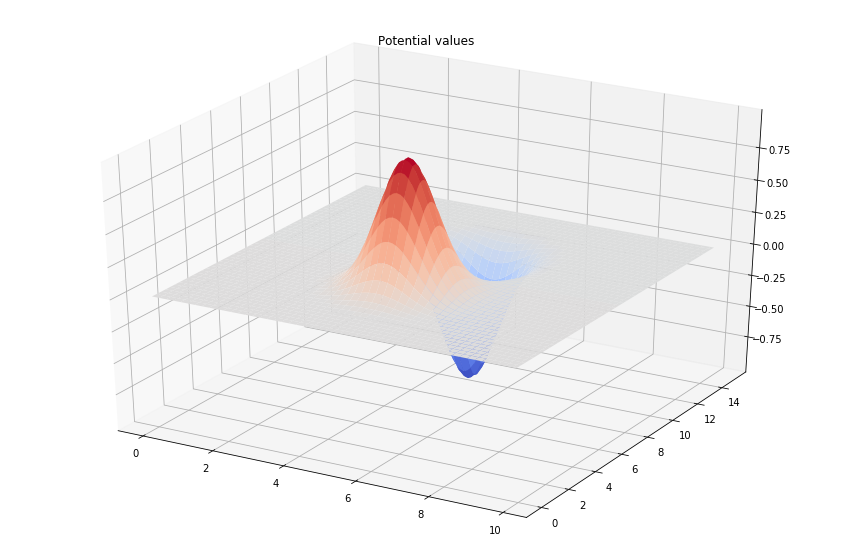

In [194]:
#needed to change those dimensions, probably it is saved in the class in a different way than I expected it
y = np.arange(0, first.x_max, first.delta )
x = np.arange(0, first.y_max, first.delta)

X,Y = np.meshgrid( x, y )

figure = plt.figure(figsize=(15,10))
figure_ext = figure.add_subplot(111, projection='3d')

figure_ext.plot_surface(X,Y, first.potential_values, cmap=cm.coolwarm)
plt.title("Potential values")
#plt.plot(first.V_old)
plt.show()

<h2>Plotting potential values for omega G = 0.6  </h2>

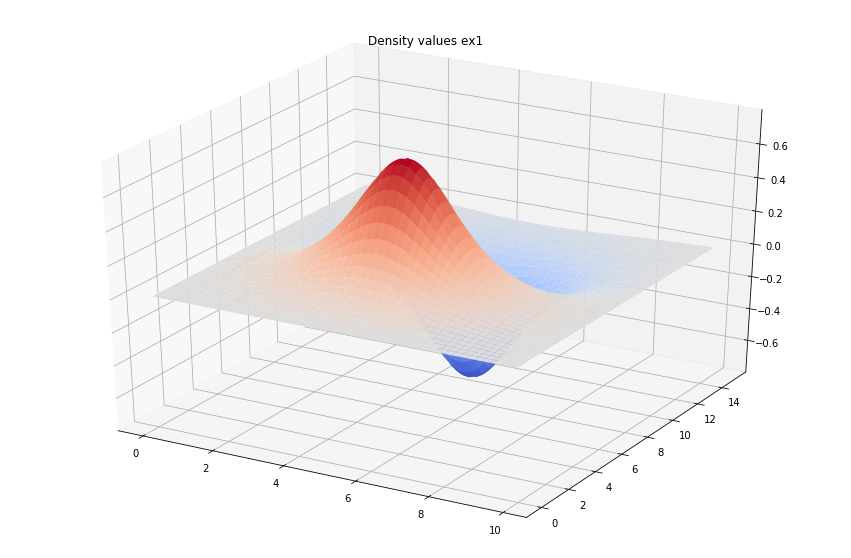

In [210]:
figure2 = plt.figure(figsize=(15,10))
figure_ext2 = figure2.add_subplot(111, projection='3d')

figure_ext2.plot_surface(X,Y, first.V_old, cmap=cm.coolwarm)
plt.title("Density values ex1")
#plt.plot(first.V_old)
plt.show()

<h2>Plotting potential values for omega G = 1.0 </h2>

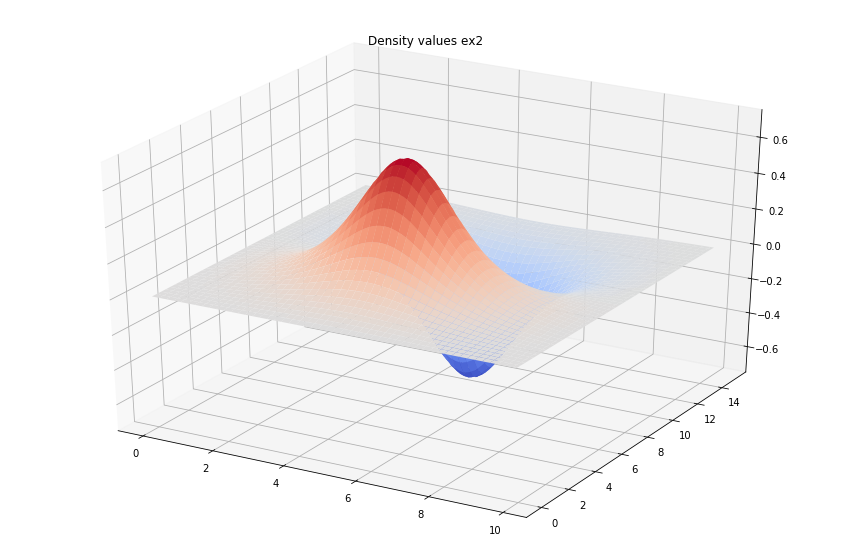

In [198]:
figure3 = plt.figure(figsize=(15,10))
figure_ext3 = figure3.add_subplot(111, projection='3d')

figure_ext3.plot_surface(X,Y, second.V_old, cmap=cm.coolwarm)
plt.title("Density values ex2")
#plt.plot(first.V_old)
plt.show()

<h2>Plotting the values of the functional integral for the global relaxation method </h2>

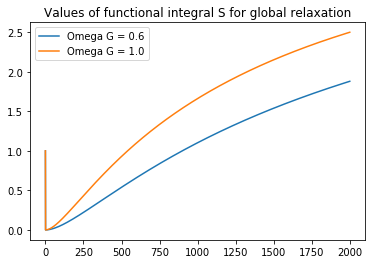

In [239]:
t_tab = np.arange(first.max_iterations+1)
plt.figure(0)
plt.title(label= "Values of functional integral S for global relaxation")
plt.plot(t_tab, first.integral_values, label='Omega G = 0.6')
plt.plot(t_tab, second.integral_values, label='Omega G = 1.0')
plt.legend()
plt.show()

<h2> 3.Metoda relaksacji lokalnej.</h2>

Warning! Somewhere here the real spaghetti begins...

In [231]:
local1 = Local_relaxation_method(omega_L=1.0, TOL=1e-6,max_iterations=2000)
local1.calculate_density()

Iteration 0 Integral value = -0.02304622954431672
Iteration 0 Eror = 1.0230462295443168
Iteration 1 Integral value = -0.04576095127401957
Iteration 1 Eror = 0.9856155292571221
Iteration 2 Integral value = -0.06815356560500987
Iteration 2 Eror = 0.48933891686171166
Iteration 3 Integral value = -0.09023305165976168
Iteration 3 Eror = 0.3239667045846942
Iteration 4 Integral value = -0.11200799294498377
Iteration 4 Eror = 0.2413189057079442
Iteration 5 Integral value = -0.13348660106966853
Iteration 5 Eror = 0.1917596017922993
Iteration 6 Integral value = -0.15467673768200407
Iteration 6 Eror = 0.15874354761101536
Iteration 7 Integral value = -0.17558593478489123
Iteration 7 Eror = 0.13517997221970018
Iteration 8 Integral value = -0.19622141357320286
Iteration 8 Eror = 0.1175235295104472
Iteration 9 Integral value = -0.2165901019213183
Iteration 9 Eror = 0.10380461529249281
Iteration 10 Integral value = -0.23669865063652126
Iteration 10 Eror = 0.09284149431033502
Iteration 11 Integral valu

Iteration 91 Integral value = -1.3384127529718215
Iteration 91 Eror = 0.007176746937871193
Iteration 92 Integral value = -1.3478825800184542
Iteration 92 Eror = 0.007075416029625995
Iteration 93 Integral value = -1.3572860086332768
Iteration 93 Eror = 0.006976444947225172
Iteration 94 Integral value = -1.3666238048572796
Iteration 94 Eror = 0.00687975575126248
Iteration 95 Integral value = -1.3758967216144076
Iteration 95 Eror = 0.00678527384359175
Iteration 96 Integral value = -1.3851054990207468
Iteration 96 Eror = 0.006692927791508997
Iteration 97 Integral value = -1.3942508646842449
Iteration 97 Eror = 0.006602649162799347
Iteration 98 Integral value = -1.403333533995489
Iteration 98 Eror = 0.006514372371073399
Iteration 99 Integral value = -1.4123542104097973
Iteration 99 Eror = 0.006428034530483289
Iteration 100 Integral value = -1.4213135857208845
Iteration 100 Eror = 0.006343575319174132
Iteration 101 Integral value = -1.4302123403265459
Iteration 101 Eror = 0.00626093685099615

Iteration 180 Integral value = -1.9852178981333948
Iteration 180 Eror = 0.0028277211969225317
Iteration 181 Integral value = -1.9907870231666287
Iteration 181 Eror = 0.0028052966067202523
Iteration 182 Integral value = -1.9963276879580185
Iteration 182 Eror = 0.0027831529575557527
Iteration 183 Integral value = -2.001840118362298
Iteration 183 Eror = 0.002761285352865983
Iteration 184 Integral value = -2.00732453772682
Iteration 184 Eror = 0.0027396890062374502
Iteration 185 Integral value = -2.012781166928124
Iteration 185 Eror = 0.0027183592382542163
Iteration 186 Integral value = -2.018210224408261
Iteration 186 Eror = 0.0026972914737784163
Iteration 187 Integral value = -2.0236119262098162
Iteration 187 Eror = 0.0026764812387861424
Iteration 188 Integral value = -2.0289864860109255
Iteration 188 Eror = 0.0026559241579365844
Iteration 189 Integral value = -2.034334115159194
Iteration 189 Eror = 0.0026356159516775553
Iteration 190 Integral value = -2.0396550227052237
Iteration 190 Er

Iteration 268 Integral value = -2.386438475147247
Iteration 268 Eror = 0.0015674285128492453
Iteration 269 Integral value = -2.390157793086009
Iteration 269 Eror = 0.001558522449874911
Iteration 270 Integral value = -2.3938618076478915
Iteration 270 Eror = 0.0015496945735536248
Iteration 271 Integral value = -2.397550614495805
Iteration 271 Eror = 0.0015409439409279
Iteration 272 Integral value = -2.4012243084730898
Iteration 272 Eror = 0.001532269623453654
Iteration 273 Integral value = -2.4048829836129086
Iteration 273 Eror = 0.0015236707070258619
Iteration 274 Integral value = -2.408526733146843
Iteration 274 Eror = 0.0015151462914258847
Iteration 275 Integral value = -2.412155649513887
Iteration 275 Eror = 0.0015066954902770186
Iteration 276 Integral value = -2.415769824368925
Iteration 276 Eror = 0.001498317430621272
Iteration 277 Integral value = -2.419369348591504
Iteration 277 Eror = 0.0014900112528391813
Iteration 278 Integral value = -2.4229543122941073
Iteration 278 Eror = 0

Iteration 357 Integral value = -2.6667079914950116
Iteration 357 Eror = 0.001000749125232322
Iteration 358 Integral value = -2.6693647742513322
Iteration 358 Eror = 0.000996278094487276
Iteration 359 Integral value = -2.672012350291584
Iteration 359 Eror = 0.0009918374835054611
Iteration 360 Integral value = -2.674650767458757
Iteration 360 Eror = 0.0009874270105396303
Iteration 361 Integral value = -2.6772800732593023
Iteration 361 Eror = 0.0009830463971351522
Iteration 362 Integral value = -2.6799003148662934
Iteration 362 Eror = 0.0009786953681694135
Iteration 363 Integral value = -2.682511539122365
Iteration 363 Eror = 0.0009743736517310307
Iteration 364 Integral value = -2.6851137925426283
Iteration 364 Eror = 0.0009700809790793337
Iteration 365 Integral value = -2.6877071213176666
Iteration 365 Eror = 0.0009658170846393287
Iteration 366 Integral value = -2.690291571316411
Iteration 366 Eror = 0.000961581705925288
Iteration 367 Integral value = -2.692867188089029
Iteration 367 Ero

Iteration 447 Integral value = -2.873821591994992
Iteration 447 Eror = 0.0006938973020749667
Iteration 448 Integral value = -2.875808357430757
Iteration 448 Eror = 0.0006913322111919392
Iteration 449 Integral value = -2.8777891608317128
Iteration 449 Eror = 0.000688781432823041
Iteration 450 Integral value = -2.879764028849324
Iteration 450 Eror = 0.0006862448592448329
Iteration 451 Integral value = -2.8817329879755724
Iteration 451 Eror = 0.0006837223836826436
Iteration 452 Integral value = -2.883696064544278
Iteration 452 Eror = 0.0006812139004192069
Iteration 453 Integral value = -2.8856532847323093
Iteration 453 Eror = 0.0006787193047477621
Iteration 454 Integral value = -2.8876046745606527
Iteration 454 Eror = 0.0006762384929152853
Iteration 455 Integral value = -2.8895502598957257
Iteration 455 Eror = 0.0006737713621996961
Iteration 456 Integral value = -2.8914900664505008
Iteration 456 Eror = 0.0006713178108364533
Iteration 457 Integral value = -2.893424119785564
Iteration 457 E

Iteration 536 Integral value = -3.0299781792704037
Iteration 536 Eror = 0.0005115092636629845
Iteration 537 Integral value = -3.0315231322958125
Iteration 537 Eror = 0.0005098891589314399
Iteration 538 Integral value = -3.0330639850506045
Iteration 538 Eror = 0.0005082767597504955
Iteration 539 Integral value = -3.034600753696968
Iteration 539 Eror = 0.0005066720167916309
Iteration 540 Integral value = -3.036133454312194
Iteration 540 Eror = 0.0005050748812207596
Iteration 541 Integral value = -3.0376621028889463
Iteration 541 Eror = 0.0005034853045017346
Iteration 542 Integral value = -3.0391867153360566
Iteration 542 Eror = 0.0005019032385663458
Iteration 543 Integral value = -3.0407073074788538
Iteration 543 Eror = 0.0005003286356590523
Iteration 544 Integral value = -3.042223895059889
Iteration 544 Eror = 0.0004987614484647344
Iteration 545 Integral value = -3.0437364937392952
Iteration 545 Eror = 0.0004972016299859582
Iteration 546 Integral value = -3.0452451190954997
Iteration 54

Iteration 624 Integral value = -3.1518330388501354
Iteration 624 Eror = 0.0003938204804348215
Iteration 625 Integral value = -3.1530708445861433
Iteration 625 Eror = 0.00039272566812721395
Iteration 626 Integral value = -3.154305698744499
Iteration 626 Eror = 0.0003916353990193523
Iteration 627 Integral value = -3.155537611723542
Iteration 627 Eror = 0.00039054964759221923
Iteration 628 Integral value = -3.1567665938723115
Iteration 628 Eror = 0.000389468388588906
Iteration 629 Integral value = -3.1579926554906277
Iteration 629 Eror = 0.0003883915968624729
Iteration 630 Integral value = -3.159215806829382
Iteration 630 Eror = 0.00038731924744275943
Iteration 631 Integral value = -3.1604360580909074
Iteration 631 Eror = 0.00038625131555986285
Iteration 632 Integral value = -3.161653419429333
Iteration 632 Eror = 0.00038518777663889387
Iteration 633 Integral value = -3.162867900950607
Iteration 633 Eror = 0.00038412860619404106
Iteration 634 Integral value = -3.1640795127129424
Iteration

Iteration 712 Integral value = -3.250497325616487
Iteration 712 Eror = 0.0003124343278890317
Iteration 713 Integral value = -3.25151036995521
Iteration 713 Eror = 0.0003116582594114754
Iteration 714 Integral value = -3.2525212158736627
Iteration 714 Eror = 0.0003108850360106644
Iteration 715 Integral value = -3.25352987033071
Iteration 715 Eror = 0.0003101146434109905
Iteration 716 Integral value = -3.2545363402548633
Iteration 716 Eror = 0.0003093470674209314
Iteration 717 Integral value = -3.2555406325444536
Iteration 717 Eror = 0.00030858229394103726
Iteration 718 Integral value = -3.256542754067815
Iteration 718 Eror = 0.000307820308966037
Iteration 719 Integral value = -3.257542711663386
Iteration 719 Eror = 0.00030706109855980395
Iteration 720 Integral value = -3.2585405121398834
Iteration 720 Eror = 0.0003063046488768655
Iteration 721 Integral value = -3.259536162276604
Iteration 721 Eror = 0.0003055509462015849
Iteration 722 Integral value = -3.260529668823197
Iteration 722 Ero

Iteration 801 Integral value = -3.332771582984702
Iteration 801 Eror = 0.0002530760814170739
Iteration 802 Integral value = -3.3336131277280847
Iteration 802 Eror = 0.0002525059766109326
Iteration 803 Integral value = -3.33445299065356
Iteration 803 Eror = 0.0002519377304130942
Iteration 804 Integral value = -3.335291176551276
Iteration 804 Eror = 0.0002513713343884748
Iteration 805 Integral value = -3.3361276901921286
Iteration 805 Eror = 0.0002508067801497139
Iteration 806 Integral value = -3.336962536327954
Iteration 806 Eror = 0.0002502440593864396
Iteration 807 Integral value = -3.337795719691436
Iteration 807 Eror = 0.00024968316377896993
Iteration 808 Integral value = -3.338627244996385
Iteration 808 Eror = 0.00024912408510907667
Iteration 809 Integral value = -3.339457116937697
Iteration 809 Eror = 0.0002485668151650481
Iteration 810 Integral value = -3.3402853401915262
Iteration 810 Eror = 0.0002480113458047684
Iteration 811 Integral value = -3.3411119194153653
Iteration 811 E

Iteration 889 Integral value = -3.400873767446679
Iteration 889 Eror = 0.00020919612256276878
Iteration 890 Integral value = -3.4015837402031037
Iteration 890 Eror = 0.00020876186679455935
Iteration 891 Integral value = -3.4022923883338594
Iteration 891 Eror = 0.00020832887998028534
Iteration 892 Integral value = -3.4029997152481775
Iteration 892 Eror = 0.0002078971568532532
Iteration 893 Integral value = -3.4037057243428097
Iteration 893 Eror = 0.0002074666922447172
Iteration 894 Integral value = -3.4044104190018634
Iteration 894 Eror = 0.00020703748094724427
Iteration 895 Integral value = -3.405113802596998
Iteration 895 Eror = 0.00020660951782090601
Iteration 896 Integral value = -3.405815878487509
Iteration 896 Eror = 0.00020618279776016084
Iteration 897 Integral value = -3.4065166500201993
Iteration 897 Eror = 0.00020575731563079425
Iteration 898 Integral value = -3.4072161205296356
Iteration 898 Eror = 0.0002053330663838554
Iteration 899 Integral value = -3.407914293338162
Iterat

Iteration 979 Integral value = -3.459836913476951
Iteration 979 Eror = 0.0001746434119266134
Iteration 980 Integral value = -3.4604399811248774
Iteration 980 Eror = 0.00017430522391884365
Iteration 981 Integral value = -3.4610419866915425
Iteration 981 Eror = 0.0001739679260292871
Iteration 982 Integral value = -3.461642932655
Iteration 982 Eror = 0.00017363151495071295
Iteration 983 Integral value = -3.4622428214848857
Iteration 983 Eror = 0.000173295987355296
Iteration 984 Integral value = -3.462841655642498
Iteration 984 Eror = 0.00017296133994310309
Iteration 985 Integral value = -3.463439437580826
Iteration 985 Eror = 0.00017262756942806583
Iteration 986 Integral value = -3.4640361697446203
Iteration 986 Eror = 0.0001722946725498717
Iteration 987 Integral value = -3.464631854570406
Iteration 987 Eror = 0.0001719626460567391
Iteration 988 Integral value = -3.4652264944865343
Iteration 988 Eror = 0.00017163148671743832
Iteration 989 Integral value = -3.4658200919131446
Iteration 989

Iteration 1066 Integral value = -3.5085758471881987
Iteration 1066 Eror = 0.00014823059624431408
Iteration 1067 Integral value = -3.509094972235511
Iteration 1067 Eror = 0.00014795890695315877
Iteration 1068 Integral value = -3.509613222996139
Iteration 1068 Eror = 0.000147687869587104
Iteration 1069 Integral value = -3.5101306013399833
Iteration 1069 Eror = 0.00014741748191911852
Iteration 1070 Integral value = -3.5106471091311744
Iteration 1070 Eror = 0.00014714774173755273
Iteration 1071 Integral value = -3.5111627482282
Iteration 1071 Eror = 0.00014687864686951642
Iteration 1072 Integral value = -3.51167752048368
Iteration 1072 Eror = 0.00014661019508129482
Iteration 1073 Integral value = -3.5121914277447033
Iteration 1073 Eror = 0.0001463423842382379
Iteration 1074 Integral value = -3.5127044718525613
Iteration 1074 Eror = 0.0001460752121325748
Iteration 1075 Integral value = -3.513216654642978
Iteration 1075 Eror = 0.0001458086766253152
Iteration 1076 Integral value = -3.51372797

Iteration 1152 Integral value = -3.550204996299013
Iteration 1152 Eror = 0.00012704036887839975
Iteration 1153 Integral value = -3.550655224594828
Iteration 1153 Eror = 0.0001268175489258594
Iteration 1154 Integral value = -3.5511047205798527
Iteration 1154 Eror = 0.00012659522161182046
Iteration 1155 Integral value = -3.5515534857052686
Iteration 1155 Eror = 0.00012637338539051577
Iteration 1156 Integral value = -3.552001521418263
Iteration 1156 Eror = 0.00012615203876209467
Iteration 1157 Integral value = -3.5524488291619125
Iteration 1157 Eror = 0.00012593118019581682
Iteration 1158 Integral value = -3.5528954103753074
Iteration 1158 Eror = 0.0001257108081976992
Iteration 1159 Integral value = -3.5533412664934487
Iteration 1159 Eror = 0.0001254909212467358
Iteration 1160 Integral value = -3.5537863989474006
Iteration 1160 Eror = 0.00012527151786664902
Iteration 1161 Integral value = -3.5542308091641805
Iteration 1161 Eror = 0.00012505259655212235
Iteration 1162 Integral value = -3.5

Iteration 1238 Integral value = -3.586388429544544
Iteration 1238 Eror = 0.0001095346144037165
Iteration 1239 Integral value = -3.58678059813832
Iteration 1239 Eror = 0.00010934916880316911
Iteration 1240 Integral value = -3.5871721458316554
Iteration 1240 Eror = 0.00010916410486296037
Iteration 1241 Integral value = -3.5875630737769773
Iteration 1241 Eror = 0.00010897942151342527
Iteration 1242 Integral value = -3.5879533831238124
Iteration 1242 Eror = 0.00010879511769091564
Iteration 1243 Integral value = -3.588343075018684
Iteration 1243 Eror = 0.00010861119230387886
Iteration 1244 Integral value = -3.588732150605228
Iteration 1244 Eror = 0.00010842764429425679
Iteration 1245 Integral value = -3.589120611024176
Iteration 1245 Eror = 0.00010824447260083165
Iteration 1246 Integral value = -3.5895084574133715
Iteration 1246 Eror = 0.00010806167616776189
Iteration 1247 Integral value = -3.5898956909077757
Iteration 1247 Eror = 0.00010787925394197696
Iteration 1248 Integral value = -3.59

Iteration 1326 Integral value = -3.618642459809794
Iteration 1326 Eror = 9.456704857025503e-05
Iteration 1327 Integral value = -3.618984101184783
Iteration 1327 Eror = 9.441147579050377e-05
Iteration 1328 Integral value = -3.6193252128877287
Iteration 1328 Eror = 9.425620378769654e-05
Iteration 1329 Integral value = -3.619665795848487
Iteration 1329 Eror = 9.410123178364542e-05
Iteration 1330 Integral value = -3.6200058509946946
Iteration 1330 Eror = 9.394655898829879e-05
Iteration 1331 Integral value = -3.6203453792519498
Iteration 1331 Eror = 9.379218466231067e-05
Iteration 1332 Integral value = -3.620684381543607
Iteration 1332 Eror = 9.363810801041408e-05
Iteration 1333 Integral value = -3.621022858790874
Iteration 1333 Eror = 9.348432826460925e-05
Iteration 1334 Integral value = -3.6213608119129357
Iteration 1334 Eror = 9.333084469248568e-05
Iteration 1335 Integral value = -3.621698241826755
Iteration 1335 Eror = 9.31776565066986e-05
Iteration 1336 Integral value = -3.622035149447

Iteration 1414 Integral value = -3.646776583561948
Iteration 1414 Eror = 8.194880654374067e-05
Iteration 1415 Integral value = -3.6470749519078334
Iteration 1415 Eror = 8.181700717015964e-05
Iteration 1416 Integral value = -3.647372864865112
Iteration 1416 Eror = 8.168544962932343e-05
Iteration 1417 Integral value = -3.6476703231981413
Iteration 1417 Eror = 8.155413335853771e-05
Iteration 1418 Integral value = -3.6479673276696265
Iteration 1418 Eror = 8.142305777918313e-05
Iteration 1419 Integral value = -3.648263879040631
Iteration 1419 Eror = 8.129222231656455e-05
Iteration 1420 Integral value = -3.648559978070617
Iteration 1420 Eror = 8.116162640733303e-05
Iteration 1421 Integral value = -3.6488556255174447
Iteration 1421 Eror = 8.10312694884026e-05
Iteration 1422 Integral value = -3.6491508221373863
Iteration 1422 Eror = 8.090115100120843e-05
Iteration 1423 Integral value = -3.6494455686849947
Iteration 1423 Eror = 8.077127035154333e-05
Iteration 1424 Integral value = -3.6497398659

Iteration 1502 Integral value = -3.671370033246607
Iteration 1502 Eror = 7.121737316956994e-05
Iteration 1503 Integral value = -3.671631085460123
Iteration 1503 Eror = 7.110484945735491e-05
Iteration 1504 Integral value = -3.671891743816349
Iteration 1504 Eror = 7.099252352942794e-05
Iteration 1505 Integral value = -3.672152008953388
Iteration 1505 Eror = 7.088039495641917e-05
Iteration 1506 Integral value = -3.6724118815080966
Iteration 1506 Eror = 7.076846330846333e-05
Iteration 1507 Integral value = -3.672671362116045
Iteration 1507 Eror = 7.065672814504123e-05
Iteration 1508 Integral value = -3.672930451411498
Iteration 1508 Eror = 7.054518902115006e-05
Iteration 1509 Integral value = -3.673189150027618
Iteration 1509 Eror = 7.043384554715413e-05
Iteration 1510 Integral value = -3.6734474585962147
Iteration 1510 Eror = 7.032269726556321e-05
Iteration 1511 Integral value = -3.6737053777479094
Iteration 1511 Eror = 7.021174376433572e-05
Iteration 1512 Integral value = -3.673962908112

Iteration 1589 Integral value = -3.692673112658571
Iteration 1589 Eror = 6.21244253673787e-05
Iteration 1590 Integral value = -3.6929021603546457
Iteration 1590 Eror = 6.202761227076915e-05
Iteration 1591 Integral value = -3.6931308653437847
Iteration 1591 Eror = 6.193096356416815e-05
Iteration 1592 Integral value = -3.6933592281664214
Iteration 1592 Eror = 6.183447891859654e-05
Iteration 1593 Integral value = -3.6935872493619675
Iteration 1593 Eror = 6.173815799101236e-05
Iteration 1594 Integral value = -3.693814929468834
Iteration 1594 Eror = 6.164200044439417e-05
Iteration 1595 Integral value = -3.6940422690245236
Iteration 1595 Eror = 6.154600596685393e-05
Iteration 1596 Integral value = -3.6942692685654452
Iteration 1596 Eror = 6.145017419673152e-05
Iteration 1597 Integral value = -3.6944959286270365
Iteration 1597 Eror = 6.135450480555743e-05
Iteration 1598 Integral value = -3.6947222497438035
Iteration 1598 Eror = 6.125899747604287e-05
Iteration 1599 Integral value = -3.69494823

Iteration 1676 Integral value = -3.711373345277966
Iteration 1676 Eror = 5.4282874150645606e-05
Iteration 1677 Integral value = -3.711574498717037
Iteration 1677 Eror = 5.419919268625312e-05
Iteration 1678 Integral value = -3.711775352981368
Iteration 1678 Eror = 5.4115649409768256e-05
Iteration 1679 Integral value = -3.7119759085331343
Iteration 1679 Eror = 5.4032244059505374e-05
Iteration 1680 Integral value = -3.712176165833695
Iteration 1680 Eror = 5.394897636605927e-05
Iteration 1681 Integral value = -3.7123761253436274
Iteration 1681 Eror = 5.386584606965364e-05
Iteration 1682 Integral value = -3.712575787522621
Iteration 1682 Eror = 5.378285288245593e-05
Iteration 1683 Integral value = -3.7127751528296917
Iteration 1683 Eror = 5.369999657399286e-05
Iteration 1684 Integral value = -3.712974221722919
Iteration 1684 Eror = 5.3617276843626e-05
Iteration 1685 Integral value = -3.713172994659699
Iteration 1685 Eror = 5.353469345871736e-05
Iteration 1686 Integral value = -3.71337147209

Iteration 1763 Integral value = -3.727801736104111
Iteration 1763 Eror = 4.7492623331956e-05
Iteration 1764 Integral value = -3.727978508576202
Iteration 1764 Eror = 4.7420030517947236e-05
Iteration 1765 Integral value = -3.728155019243381
Iteration 1765 Eror = 4.734755492107149e-05
Iteration 1766 Integral value = -3.728331268503913
Iteration 1766 Eror = 4.727519634302005e-05
Iteration 1767 Integral value = -3.728507256755332
Iteration 1767 Eror = 4.720295455118631e-05
Iteration 1768 Integral value = -3.7286829843945615
Iteration 1768 Eror = 4.7130829344898317e-05
Iteration 1769 Integral value = -3.728858451817835
Iteration 1769 Eror = 4.705882050252866e-05
Iteration 1770 Integral value = -3.729033659420726
Iteration 1770 Eror = 4.69869278104402e-05
Iteration 1771 Integral value = -3.7292086075981556
Iteration 1771 Eror = 4.6915151057386245e-05
Iteration 1772 Integral value = -3.7293832967443734
Iteration 1772 Eror = 4.684349002676912e-05
Iteration 1773 Integral value = -3.729557727252

Iteration 1851 Integral value = -3.742397723886216
Iteration 1851 Eror = 4.1530604600331575e-05
Iteration 1852 Integral value = -3.742552911960709
Iteration 1852 Eror = 4.146755260744062e-05
Iteration 1853 Integral value = -3.7427078708692987
Iteration 1853 Eror = 4.140460061216567e-05
Iteration 1854 Integral value = -3.742862600956479
Iteration 1854 Eror = 4.1341748412845406e-05
Iteration 1855 Integral value = -3.7430171025663217
Iteration 1855 Eror = 4.127899586890485e-05
Iteration 1856 Integral value = -3.7431713760422474
Iteration 1856 Eror = 4.121634277863596e-05
Iteration 1857 Integral value = -3.7433254217271688
Iteration 1857 Eror = 4.115378897886995e-05
Iteration 1858 Integral value = -3.743479239963397
Iteration 1858 Eror = 4.109133428137921e-05
Iteration 1859 Integral value = -3.743632831092728
Iteration 1859 Eror = 4.1028978521165674e-05
Iteration 1860 Integral value = -3.7437861954564555
Iteration 1860 Eror = 4.096672153688168e-05
Iteration 1861 Integral value = -3.7439393

Iteration 1937 Integral value = -3.7549404139118914
Iteration 1937 Eror = 3.6456286737659364e-05
Iteration 1938 Integral value = -3.7550770983426984
Iteration 1938 Eror = 3.6401224983662816e-05
Iteration 1939 Integral value = -3.7552135813111214
Iteration 1939 Eror = 3.634624931753944e-05
Iteration 1940 Integral value = -3.7553498631175235
Iteration 1940 Eror = 3.629135958614243e-05
Iteration 1941 Integral value = -3.7554859440618196
Iteration 1941 Eror = 3.623655564893236e-05
Iteration 1942 Integral value = -3.7556218244435207
Iteration 1942 Eror = 3.618183737738296e-05
Iteration 1943 Integral value = -3.755757504561569
Iteration 1943 Eror = 3.61272045990478e-05
Iteration 1944 Integral value = -3.7558929847144733
Iteration 1944 Eror = 3.607265717761958e-05
Iteration 1945 Integral value = -3.7560282652003325
Iteration 1945 Eror = 3.601819498312617e-05
Iteration 1946 Integral value = -3.7561633463166664
Iteration 1946 Eror = 3.596381784061564e-05
Iteration 1947 Integral value = -3.75629

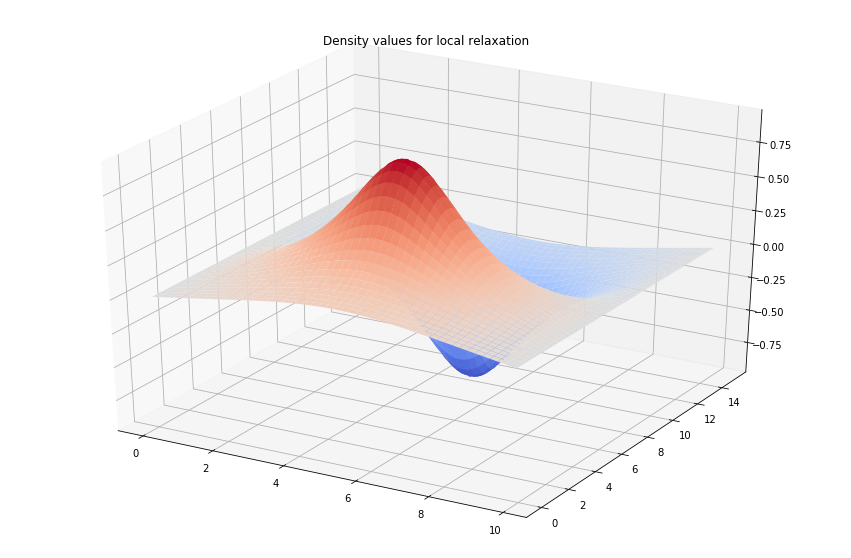

In [226]:
figure_local1 = plt.figure(figsize=(15,10))
figure_local1_ext = figure_local1.add_subplot(111, projection='3d')

figure_local1_ext.plot_surface(X,Y, local1.V, cmap=cm.coolwarm)
plt.title("Density values for local relaxation")
plt.show()

In [227]:
local2 = Local_relaxation_method(omega_L=1.4, TOL=1e-8,max_iterations=2000)
local2.calculate_density()

Iteration 0 Integral value = -0.052476826233702756
Iteration 0 Eror = 1.0524768262337028
Iteration 1 Integral value = -0.10330865755674358
Iteration 1 Eror = 0.968652926849348
Iteration 2 Integral value = -0.1525920520528395
Iteration 2 Eror = 0.47704999427590455
Iteration 3 Integral value = -0.2004149732035597
Iteration 3 Eror = 0.31340374880180594
Iteration 4 Integral value = -0.24685779622092868
Iteration 4 Eror = 0.23173329953844032
Iteration 5 Integral value = -0.29199417112694953
Iteration 5 Eror = 0.18284362737170937
Iteration 6 Integral value = -0.335891766292488
Iteration 6 Eror = 0.15033723103483884
Iteration 7 Integral value = -0.3786129117122401
Iteration 7 Eror = 0.12718723620796152
Iteration 8 Integral value = -0.42021515777567325
Iteration 8 Eror = 0.10988068493303897
Iteration 9 Integral value = -0.46075176248830213
Iteration 9 Eror = 0.09646630770579877
Iteration 10 Integral value = -0.5002721178461372
Iteration 10 Eror = 0.08577363902940788
Iteration 11 Integral value

Iteration 92 Integral value = -2.1639779711357883
Iteration 92 Eror = 0.00511599207514765
Iteration 93 Integral value = -2.1748734449025915
Iteration 93 Eror = 0.005034928225764059
Iteration 94 Integral value = -2.1856518153116076
Iteration 94 Eror = 0.0049558609648198745
Iteration 95 Integral value = -2.196315004354801
Iteration 95 Eror = 0.0048787226622706075
Iteration 96 Integral value = -2.2068648906248076
Iteration 96 Eror = 0.004803448616928059
Iteration 97 Integral value = -2.21730331058278
Iteration 97 Eror = 0.004729976901765491
Iteration 98 Integral value = -2.227632059780166
Iteration 98 Eror = 0.004658248218946223
Iteration 99 Integral value = -2.237852894035996
Iteration 99 Eror = 0.004588205763585004
Iteration 100 Integral value = -2.2479675305721156
Iteration 100 Eror = 0.004519795096038539
Iteration 101 Integral value = -2.257977649107957
Iteration 101 Eror = 0.004452964021812997
Iteration 102 Integral value = -2.2678848929166926
Iteration 102 Eror = 0.00438766247870058

Iteration 181 Integral value = -2.8223686942416557
Iteration 181 Eror = 0.0017813885771932765
Iteration 182 Integral value = -2.8273510606663947
Iteration 182 Eror = 0.0017653138071238965
Iteration 183 Integral value = -2.8322973909636127
Iteration 183 Eror = 0.0017494574218357188
Iteration 184 Integral value = -2.837208071855021
Iteration 184 Eror = 0.0017338154203283046
Iteration 185 Integral value = -2.842083484511221
Iteration 185 Eror = 0.0017183838945630885
Iteration 186 Integral value = -2.8469240046530917
Iteration 186 Eror = 0.0017031590269077227
Iteration 187 Integral value = -2.851730002650763
Iteration 187 Eror = 0.0016881370875430058
Iteration 188 Integral value = -2.8565018436205185
Iteration 188 Eror = 0.0016733144320534939
Iteration 189 Integral value = -2.8612398875193126
Iteration 189 Eror = 0.001658687498968583
Iteration 190 Integral value = -2.865944489237546
Iteration 190 Eror = 0.001644252807586909
Iteration 191 Integral value = -2.870615998689444
Iteration 191 Er

Iteration 269 Integral value = -3.1553919203098366
Iteration 269 Eror = 0.0009102185842297221
Iteration 270 Integral value = -3.1582454881485735
Iteration 270 Eror = 0.0009043465632176414
Iteration 271 Integral value = -3.1610832693259705
Iteration 271 Eror = 0.000898530905227552
Iteration 272 Integral value = -3.1639053924262552
Iteration 272 Eror = 0.0008927708825862371
Iteration 273 Integral value = -3.1667119846285865
Iteration 273 Eror = 0.0008870657792264173
Iteration 274 Integral value = -3.1695031717259115
Iteration 274 Eror = 0.0008814148905468975
Iteration 275 Integral value = -3.1722790781430406
Iteration 275 Eror = 0.0008758175230402184
Iteration 276 Integral value = -3.1750398269550257
Iteration 276 Eror = 0.0008702729942667095
Iteration 277 Integral value = -3.177785539904648
Iteration 277 Eror = 0.000864780632454517
Iteration 278 Integral value = -3.180516337420122
Iteration 278 Eror = 0.0008593397764519129
Iteration 279 Integral value = -3.1832323386322945
Iteration 279

Iteration 357 Integral value = -3.3575078152185474
Iteration 357 Eror = 0.0005498362014005957
Iteration 358 Integral value = -3.3593445007732554
Iteration 358 Eror = 0.0005470383557658251
Iteration 359 Integral value = -3.3611728608556133
Iteration 359 Eror = 0.0005442609657738345
Iteration 360 Integral value = -3.3629929488102017
Iteration 360 Eror = 0.0005415038231997137
Iteration 361 Integral value = -3.364804817498968
Iteration 361 Eror = 0.0005387667224836984
Iteration 362 Integral value = -3.3666085193065034
Iteration 362 Eror = 0.0005360494606269897
Iteration 363 Integral value = -3.368404106145457
Iteration 363 Eror = 0.0005333518372142954
Iteration 364 Integral value = -3.3701916294616274
Iteration 364 Eror = 0.0005306736543009702
Iteration 365 Integral value = -3.371971140239183
Iteration 365 Eror = 0.0005280147164332167
Iteration 366 Integral value = -3.3737426890059234
Iteration 366 Eror = 0.0005253748306441845
Iteration 367 Integral value = -3.3755063258379523
Iteration 36

Iteration 447 Integral value = -3.4946995500577267
Iteration 447 Eror = 0.0003608391591389769
Iteration 448 Integral value = -3.4959551286950643
Iteration 448 Eror = 0.00035928085357634433
Iteration 449 Integral value = -3.4972057419500975
Iteration 449 Eror = 0.0003577314951121782
Iteration 450 Integral value = -3.4984514151978767
Iteration 450 Eror = 0.00035619101067946806
Iteration 451 Integral value = -3.4996921736261597
Iteration 451 Eror = 0.0003546593280938258
Iteration 452 Integral value = -3.5009280422369695
Iteration 452 Eror = 0.00035313637585710617
Iteration 453 Integral value = -3.502159045848471
Iteration 453 Eror = 0.0003516220832448063
Iteration 454 Integral value = -3.503385209096872
Iteration 454 Eror = 0.0003501163803095942
Iteration 455 Integral value = -3.504606556438136
Iteration 455 Eror = 0.0003486191978240205
Iteration 456 Integral value = -3.5058231121496233
Iteration 456 Eror = 0.00034713046725673213
Iteration 457 Integral value = -3.507034900332075
Iteration

Iteration 535 Integral value = -3.5885925611395124
Iteration 535 Eror = 0.00025143837669391406
Iteration 536 Integral value = -3.58949134170067
Iteration 536 Eror = 0.00025045489167273375
Iteration 537 Integral value = -3.59038683395739
Iteration 537 Eror = 0.0002494760876886312
Iteration 538 Integral value = -3.591279052029567
Iteration 538 Eror = 0.0002485019340363609
Iteration 539 Integral value = -3.5921680099535163
Iteration 539 Eror = 0.00024753240031483777
Iteration 540 Integral value = -3.5930537216828293
Iteration 540 Eror = 0.00024656745643824354
Iteration 541 Integral value = -3.5939362010888534
Iteration 541 Eror = 0.000245607072529582
Iteration 542 Integral value = -3.594815461961555
Iteration 542 Eror = 0.00024465121902696147
Iteration 543 Integral value = -3.5956915180100046
Iteration 543 Eror = 0.00024369986657721992
Iteration 544 Integral value = -3.5965643828633547
Iteration 544 Eror = 0.00024275298617193607
Iteration 545 Integral value = -3.597434070071168
Iteration 

Iteration 622 Integral value = -3.655818348978197
Iteration 622 Eror = 0.00018065401585538315
Iteration 623 Integral value = -3.656476347592003
Iteration 623 Eror = 0.00017998668177528237
Iteration 624 Integral value = -3.6571320347487264
Iteration 624 Eror = 0.00017932213814411837
Iteration 625 Integral value = -3.6577854193112773
Iteration 625 Eror = 0.000178660370022933
Iteration 626 Integral value = -3.658436510099813
Iteration 626 Eror = 0.00017800136254530512
Iteration 627 Integral value = -3.659085315892118
Iteration 627 Eror = 0.0001773451009778933
Iteration 628 Integral value = -3.6597318454238557
Iteration 628 Eror = 0.00017669157068563363
Iteration 629 Integral value = -3.6603761073888315
Iteration 629 Eror = 0.00017604075713399295
Iteration 630 Integral value = -3.661018110439378
Iteration 630 Eror = 0.00017539264592252333
Iteration 631 Integral value = -3.66165786318658
Iteration 631 Eror = 0.00017474722274050163
Iteration 632 Integral value = -3.6622953742005135
Iteration

Iteration 710 Integral value = -3.70575722445591
Iteration 710 Eror = 0.00013119170573515704
Iteration 711 Integral value = -3.7062416512859824
Iteration 711 Eror = 0.00013072276480374437
Iteration 712 Integral value = -3.7067244101230155
Iteration 712 Eror = 0.00013025562887017232
Iteration 713 Integral value = -3.707205506958105
Iteration 713 Eror = 0.00012979028971659914
Iteration 714 Integral value = -3.7076849477575933
Iteration 714 Eror = 0.00012932673912694967
Iteration 715 Integral value = -3.7081627384633173
Iteration 715 Eror = 0.00012886496896480807
Iteration 716 Integral value = -3.7086388849927543
Iteration 716 Eror = 0.00012840497114597162
Iteration 717 Integral value = -3.7091133932390354
Iteration 717 Eror = 0.00012794673760264849
Iteration 718 Integral value = -3.709586269071242
Iteration 718 Eror = 0.0001274902603593954
Iteration 719 Integral value = -3.7100575183344313
Iteration 719 Eror = 0.00012703553146030375
Iteration 720 Integral value = -3.7105271468497523
Iter

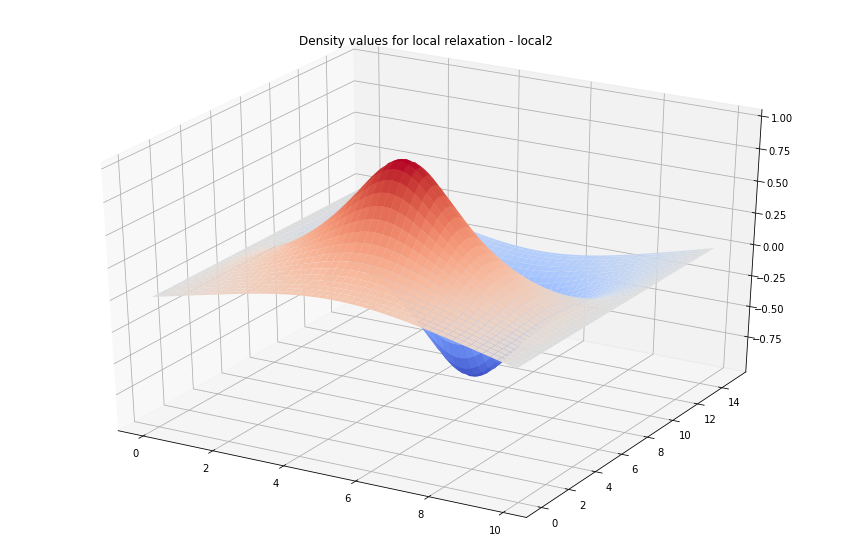

In [230]:
figure_local2 = plt.figure(figsize=(15,10))
figure_local2_ext = figure_local2.add_subplot(111, projection='3d')

figure_local2_ext.plot_surface(X,Y, local2.V, cmap=cm.coolwarm)
plt.title("Density values for local relaxation - local2")
plt.show()

In [228]:
local3 = Local_relaxation_method(omega_L=1.8, TOL=1e-8,max_iterations=2000)
local3.calculate_density()

Iteration 0 Integral value = -0.16496622035380298
Iteration 0 Eror = 1.164966220353803
Iteration 1 Integral value = -0.31673008034183664
Iteration 1 Eror = 0.9199693104597158
Iteration 2 Integral value = -0.45698058901462657
Iteration 2 Eror = 0.44280766929816723
Iteration 3 Integral value = -0.5871022450981855
Iteration 3 Eror = 0.2847421952081955
Iteration 4 Integral value = -0.7082458723698608
Iteration 4 Eror = 0.20634161814764565
Iteration 5 Integral value = -0.8213793320217198
Iteration 5 Eror = 0.15973754887310984
Iteration 6 Integral value = -0.9273248607227415
Iteration 6 Eror = 0.1289848971975596
Iteration 7 Integral value = -1.0267871802518513
Iteration 7 Eror = 0.10725725551193638
Iteration 8 Integral value = -1.1203750471643954
Iteration 8 Eror = 0.0911463141656957
Iteration 9 Integral value = -1.2086180267886018
Iteration 9 Eror = 0.07876200014231327
Iteration 10 Integral value = -1.2919797220620943
Iteration 10 Eror = 0.06897273863686404
Iteration 11 Integral value = -1.

Iteration 92 Integral value = -3.329445336491971
Iteration 92 Eror = 0.002239625072569005
Iteration 93 Integral value = -3.3367532315723114
Iteration 93 Eror = 0.0021949286868425772
Iteration 94 Integral value = -3.343932317982102
Iteration 94 Eror = 0.002151518530607025
Iteration 95 Integral value = -3.3509858275107214
Iteration 95 Eror = 0.0021093457815186036
Iteration 96 Integral value = -3.3579168853426418
Iteration 96 Eror = 0.0020683638155130956
Iteration 97 Integral value = -3.3647285140655305
Iteration 97 Eror = 0.0020285280891321716
Iteration 98 Integral value = -3.371423637504441
Iteration 98 Eror = 0.001989796029879613
Iteration 99 Integral value = -3.378005084391878
Iteration 99 Eror = 0.0019521269336263691
Iteration 100 Integral value = -3.3844755918831786
Iteration 100 Eror = 0.00191548186863241
Iteration 101 Integral value = -3.3908378089257
Iteration 101 Eror = 0.0018798235856035369
Iteration 102 Integral value = -3.39709429948991
Iteration 102 Eror = 0.0018451164333902

Iteration 182 Integral value = -3.6885438794466237
Iteration 182 Eror = 0.000553387336715105
Iteration 183 Integral value = -3.6905580490786076
Iteration 183 Eror = 0.0005460609112466767
Iteration 184 Integral value = -3.692546668094397
Iteration 184 Eror = 0.0005388396522541233
Iteration 185 Integral value = -3.694510075230412
Iteration 185 Eror = 0.0005317216849227559
Iteration 186 Integral value = -3.696448603814053
Iteration 186 Eror = 0.0005247051825999957
Iteration 187 Integral value = -3.6983625818926904
Iteration 187 Eror = 0.0005177883649355692
Iteration 188 Integral value = -3.7002523323588514
Iteration 188 Eror = 0.0005109694964504846
Iteration 189 Integral value = -3.7021181730705464
Iteration 189 Eror = 0.0005042468848348754
Iteration 190 Integral value = -3.703960416967582
Iteration 190 Eror = 0.0004976188794934761
Iteration 191 Integral value = -3.7057793721839345
Iteration 191 Eror = 0.0004910838701244835
Iteration 192 Integral value = -3.7075753421560913
Iteration 192 

Iteration 271 Integral value = -3.7966250903464127
Iteration 271 Eror = 0.0001735985406079636
Iteration 272 Integral value = -3.7972757176805385
Iteration 272 Eror = 0.00017136991897886674
Iteration 273 Integral value = -3.797918102507128
Iteration 273 Eror = 0.00016916991926561393
Iteration 274 Integral value = -3.798552347872539
Iteration 274 Eror = 0.00016699816802070056
Iteration 275 Integral value = -3.799178555549153
Iteration 275 Eror = 0.00016485429691772454
Iteration 276 Integral value = -3.7997968260513137
Iteration 276 Eror = 0.0001627379427212871
Iteration 277 Integral value = -3.800407258650749
Iteration 277 Eror = 0.00016064874712518138
Iteration 278 Integral value = -3.8010099513922304
Iteration 278 Eror = 0.0001585863567935753
Iteration 279 Integral value = -3.8016050011085207
Iteration 279 Eror = 0.00015655042315065886
Iteration 280 Integral value = -3.8021925034355255
Iteration 280 Eror = 0.00015454060241226078
Iteration 281 Integral value = -3.8027725528270397
Iterat

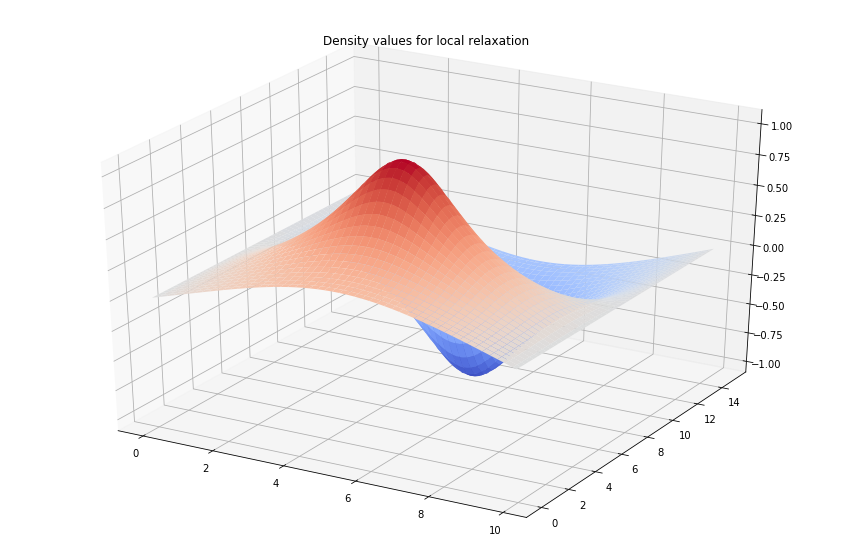

In [234]:
figure_local3 = plt.figure(figsize=(15,10))
figure_local3_ext = figure_local3.add_subplot(111, projection='3d')

figure_local3_ext.plot_surface(X,Y, local3.V, cmap=cm.coolwarm)
plt.title("Density values for local relaxation")
plt.show()

In [233]:
local4 = Local_relaxation_method(omega_L=1.9, TOL=1e-8,max_iterations=2000)
local4.calculate_density()

Iteration 0 Integral value = -0.25191486983089245
Iteration 0 Eror = 1.2519148698308924
Iteration 1 Integral value = -0.47507010721390386
Iteration 1 Eror = 0.8858359077128434
Iteration 2 Integral value = -0.6746807710143314
Iteration 2 Eror = 0.42017096165251117
Iteration 3 Integral value = -0.8546457493533594
Iteration 3 Eror = 0.26674093300223184
Iteration 4 Integral value = -1.0179736525033023
Iteration 4 Eror = 0.19110596790953424
Iteration 5 Integral value = -1.1670377010769255
Iteration 5 Eror = 0.14643212838275266
Iteration 6 Integral value = -1.3037428353110472
Iteration 6 Eror = 0.11713857582147702
Iteration 7 Integral value = -1.42964096568803
Iteration 7 Eror = 0.09656669012255475
Iteration 8 Integral value = -1.5460130123494966
Iteration 8 Eror = 0.08139949081933401
Iteration 9 Integral value = -1.6539286386624872
Iteration 9 Eror = 0.06980253429367309
Iteration 10 Integral value = -1.7542905325154363
Iteration 10 Eror = 0.060680909385613296
Iteration 11 Integral value = -

Iteration 91 Integral value = -3.6703274538670314
Iteration 91 Eror = 0.0012572989974881923
Iteration 92 Integral value = -3.6748242718646726
Iteration 92 Eror = 0.0012251816913238674
Iteration 93 Integral value = -3.679211957385416
Iteration 93 Eror = 0.0011939851258565921
Iteration 94 Integral value = -3.6834933338030353
Iteration 94 Eror = 0.0011636666947185078
Iteration 95 Integral value = -3.6876711034344885
Iteration 95 Eror = 0.0011341868310481662
Iteration 96 Integral value = -3.6917478563677006
Iteration 96 Eror = 0.0011055088208423288
Iteration 97 Integral value = -3.6957260787554382
Iteration 97 Eror = 0.0010775986179217983
Iteration 98 Integral value = -3.6996081605715068
Iteration 98 Eror = 0.001050424661715147
Iteration 99 Integral value = -3.703396402777509
Iteration 99 Eror = 0.0010239576845935076
Iteration 100 Integral value = -3.707093023846703
Iteration 100 Eror = 0.0009981705081372244
Iteration 101 Integral value = -3.7107001657397207
Iteration 101 Eror = 0.00097303

Iteration 179 Integral value = -3.8308257284149856
Iteration 179 Eror = 0.00012036041413157442
Iteration 180 Integral value = -3.8312742670567217
Iteration 180 Eror = 0.00011708667361427873
Iteration 181 Integral value = -3.8317106537372374
Iteration 181 Eror = 0.0001139011853753172
Iteration 182 Integral value = -3.8321352134106546
Iteration 182 Eror = 0.00011080160058616496
Iteration 183 Integral value = -3.8325482625193454
Iteration 183 Eror = 0.00010778563012218682
Iteration 184 Integral value = -3.832950109203763
Iteration 184 Eror = 0.00010485104345514064
Iteration 185 Integral value = -3.8333410535074286
Iteration 185 Eror = 0.00010199566718258998
Iteration 186 Integral value = -3.8337213875781573
Iteration 186 Eror = 9.92173838486625e-05
Iteration 187 Integral value = -3.834091395865064
Iteration 187 Eror = 9.651413065795633e-05
Iteration 188 Integral value = -3.8344513553116575
Iteration 188 Eror = 9.388389827678262e-05
Iteration 189 Integral value = -3.8348015355445026
Iterat

Iteration 268 Integral value = -3.8458471305309674
Iteration 268 Eror = 9.920213751958394e-06
Iteration 269 Integral value = -3.8458841962465002
Iteration 269 Eror = 9.63785461949461e-06
Iteration 270 Integral value = -3.8459202062167317
Iteration 270 Eror = 9.363248707956209e-06
Iteration 271 Integral value = -3.8459551894246853
Iteration 271 Eror = 9.096186628375355e-06
Iteration 272 Integral value = -3.845989174071644
Iteration 272 Eror = 8.836464619311e-06
Iteration 273 Integral value = -3.846022187597922
Iteration 273 Eror = 8.58388434908068e-06
Iteration 274 Integral value = -3.8460542567034497
Iteration 274 Eror = 8.338252865770317e-06
Iteration 275 Integral value = -3.8460854073676383
Iteration 275 Eror = 8.09938240842001e-06
Iteration 276 Integral value = -3.846115664868545
Iteration 276 Eror = 7.867090223376241e-06
Iteration 277 Integral value = -3.846145053801921
Iteration 277 Eror = 7.641198533022587e-06
Iteration 278 Integral value = -3.8461735980993086
Iteration 278 Eror 

Iteration 356 Integral value = -3.847016445712479
Iteration 356 Eror = 6.323345197666706e-07
Iteration 357 Integral value = -3.847018793014954
Iteration 357 Eror = 6.101617989376511e-07
Iteration 358 Integral value = -3.847021057605027
Iteration 358 Eror = 5.886610373086594e-07
Iteration 359 Integral value = -3.8470232419946884
Iteration 359 Eror = 5.67813284212372e-07
Iteration 360 Integral value = -3.847025348625205
Iteration 360 Eror = 5.47600153204127e-07
Iteration 361 Integral value = -3.847027379868805
Iteration 361 Eror = 5.280036953000223e-07
Iteration 362 Integral value = -3.8470293380307066
Iteration 362 Eror = 5.090064894685254e-07
Iteration 363 Integral value = -3.8470312253509515
Iteration 363 Eror = 4.905915913657986e-07
Iteration 364 Integral value = -3.847033044005984
Iteration 364 Eror = 4.727424670649898e-07
Iteration 365 Integral value = -3.8470347961107647
Iteration 365 Eror = 4.5544313261010305e-07
Iteration 366 Integral value = -3.847036483719957
Iteration 366 Ero

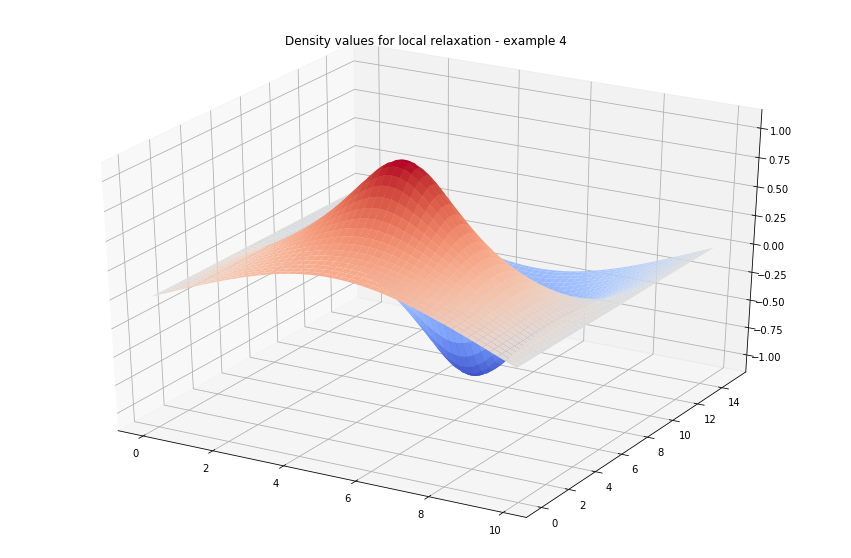

In [237]:
figure_local4 = plt.figure(figsize=(15,10))
figure_local4_ext = figure_local4.add_subplot(111, projection='3d')

figure_local4_ext.plot_surface(X,Y, local4.V, cmap=cm.coolwarm)
plt.title("Density values for local relaxation - example 4")
plt.show()

<h2>Plotting the values of the functional integral for the local relaxation method </h2>

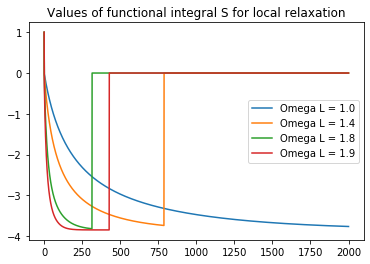

In [238]:
t_tab = np.arange(local1.max_iterations+1)
plt.figure(0)
plt.title(label= "Values of functional integral S for local relaxation")
plt.plot(t_tab, local1.integral_values, label='Omega L = 1.0')
plt.plot(t_tab, local2.integral_values, label='Omega L = 1.4')
plt.plot(t_tab, local3.integral_values, label='Omega L = 1.8')
plt.plot(t_tab, local4.integral_values, label='Omega L = 1.9')
plt.legend()
plt.show()